## **Βήμα 1 : Ανάλυση αρχείων ήχου με το Praat**

Παρακάτω παίρνουμε τις κυματομορφές και τα spectrograms για τα δύο αρχεία που μας δίνονται. Και τα δύο αρχεία περιέχουν την πρόταση "one two three" από δύο διαφορετικούς ομιλητές, έναν άντρα και μία γυναίκα. 

*male speaker*

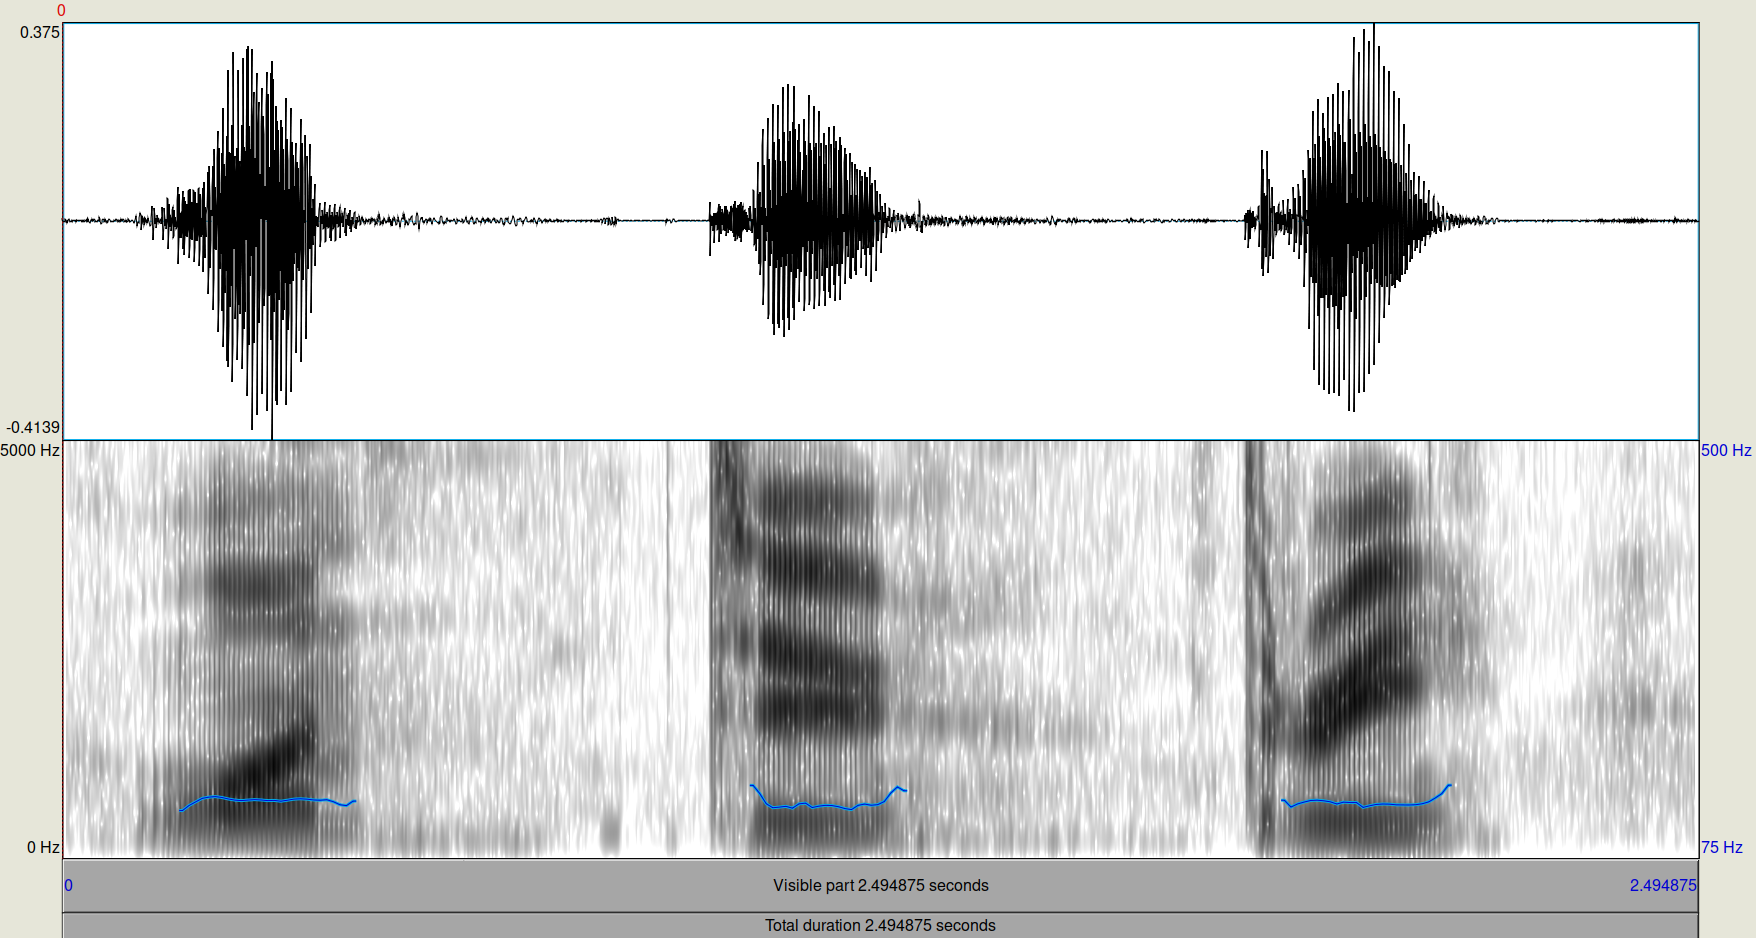

*female speaker*

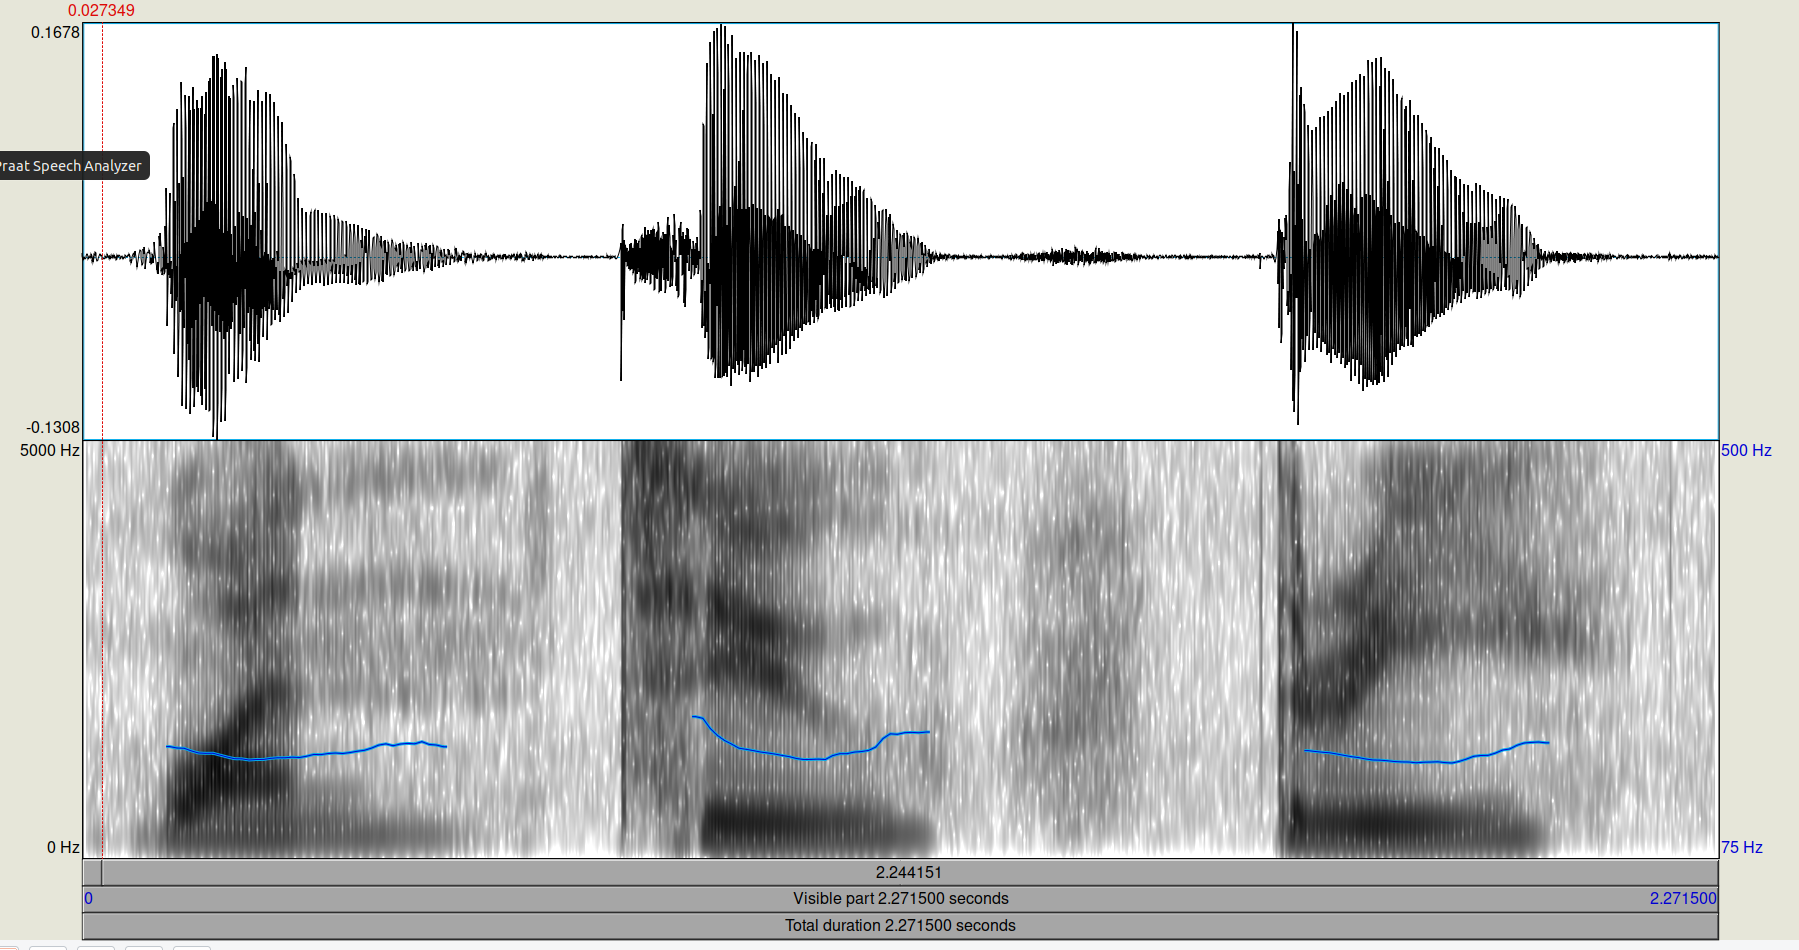

Στη συνέχεια για το κάθε φωνήεν που ζητείται, παίρνουμε το mean pitch και τα αποτελέσματα φαίνονται συγκεντρωτικά στον πίνακα : 

 φύλο| φωνήεν | mean pitch
--- | --- | ---
male | α | 134.5723062614727 Hz
male | ου | 132.25016201248198 Hz
male | ι | 136.07471764944742 Hz 
female | α | 175.83033871488075 Hz 
female | ου | 187.67179954138987 Hz 
female | ι | 181.8536856222224 Hz 

Στη συνέχεια παίρνουμε τα formants : 

 φύλο| φωνήεν | first formant | second formant | third formant 
--- | --- | --- | --- | ---
male | α | 780.6349199126736 Hz | 1214.7880002097445 Hz | 2423.6861232854794 Hz 
male | ου | 340.611674762988 Hz  | 1776.759546979861 Hz | 2222.7291834409384 Hz 
male | ι | 385.3142125927083 Hz | 2009.2899788371653 Hz | 2510.3450245951453 Hz
female | α | 903.2923712053964 Hz | 1857.584713962902 Hz | 3166.0838983757294 Hz
female | ου | 318.8989688659077 Hz | 1183.4539862472623 Hz | 2669.100421509304 Hz
female | ι | 334.6091057174193 Hz | 2689.0823724010584 Hz | 3614.980091852231 Hz 

Παρατηρούμε ότι το pitch μπορεί να είναι ικανό να μας βοηθήσει για τον διαχωρισμό του φύλου του ομιλητή, καθώς όπως φαίνεται *συνήθως* οι γυναίκες μιλάνε σε πιο υψηλές συχνότητες από ότι οι άντρες.

Τα formants από την άλλη μπορούν να μας βοηθήσουν να κάνουμε έναν ικανό διαχωρισμό μεταξύ των διάφορων φωνημάτων. 

## **Βήμα 2 : Κατασκευή Data Parser**

In [ ]:
import numpy as np
import librosa
from glob import glob
import os
import re
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sn

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
def data_parser(directory):
    '''
    reads the files of .wav
    return 3 lists : 
    i) the wav files (with librosa)
    ii) the speakers
    iii) the digits
    '''
    wavfiles = []
    files = glob(os.path.join(directory, '*.wav'))
    for w in files : 
        temp, _ = librosa.load(w)
        wavfiles.append(temp)
    fnames = [f.split('/')[3].split('.')[0].split('_') for f in files]
    items=[]
    for i in range(len(fnames)): 
        match = re.match(r"([a-z]+)([0-9]+)", str(fnames[i][0]) , re.I) #we should seperate strings which are like "eight2"
        if match:
            items.append(match.groups())
    ids = [f[0] for f in items]
    speakers = [f[1] for f in items]
    return wavfiles, ids, speakers

In [ ]:
wavfiles, ids, speakers = data_parser("./pr_lab2_2020-21_data/digits")
print (wavfiles)
print (ids)
print(speakers)

[array([0.00012223, 0.00029549, 0.00033948, ..., 0.00069192, 0.00052342,
       0.        ], dtype=float32), array([0.00116223, 0.00135009, 0.00108581, ..., 0.00091487, 0.00078559,
       0.        ], dtype=float32), array([-0.00240912, -0.00261606, -0.00184066, ..., -0.00018496,
       -0.00023441,  0.        ], dtype=float32), array([-0.00015163, -0.00025872, -0.00027478, ..., -0.00176622,
       -0.001564  ,  0.        ], dtype=float32), array([1.1713001e-04, 1.1438356e-04, 6.4712040e-05, ..., 4.7783402e-04,
       3.0717900e-04, 0.0000000e+00], dtype=float32), array([ 3.5350674e-04,  2.8995590e-04,  1.7355997e-04, ...,
        7.4115516e-05, -3.1757861e-04,  0.0000000e+00], dtype=float32), array([-0.00066116, -0.00090202, -0.00084561, ...,  0.00028853,
        0.00023373,  0.        ], dtype=float32), array([ 0.00071255,  0.00092635,  0.00110005, ..., -0.00108464,
       -0.00118022,  0.        ], dtype=float32), array([-2.6600415e-04, -1.7015416e-04, -3.0264226e-05, ...,
       -1

## **Βήμα 3 : Εξαγωγή MFCCs**


In [ ]:
Fs = 20000 #sampling rate 

#we use the existent functions of librosa
window = 25 * Fs // 1000
step = 10 // 1000
frames = [librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=13) for wav in wavfiles]
    
#frames = [librosa.feature.mfcc(wav, Fs, n_fft=int(Fs*0.025), hop_length=int(Fs*0.01), n_mfcc=13) for wav in wavfiles]
delta = [librosa.feature.delta(fra, order=1) for fra in frames]
delta_deltas = [librosa.feature.delta(fra, order=2) for fra in frames]

## **Βήμα 4 : MFCCs vs MFSCs**

**Α.Μ. = 03116028 , 
n1 = 2 ,
n2 = 8**

In [ ]:
#we want the first 2 mfcc coefficients of the number 2 and number 8
mfcc2_0 = [frames[i][0] for i in range(len(ids)) if ids[i]=='two']
mfcc2_1 = [frames[i][1] for i in range(len(ids)) if ids[i]=='two']
mfcc8_0 = [frames[i][0] for i in range(len(ids)) if ids[i]=='eight']
mfcc8_1 = [frames[i][1] for i in range(len(ids)) if ids[i]=='eight']

#then, for every number, it has been created a list of 15 arrays of the mfccs. Number 8 has 14 arrays, as 1 sample 
#is missing

In [ ]:
#we want to create a "global" list with all the values of every "array" in the list
mfcc2_0_new=[]
for l in mfcc2_0:
    for value in l:
        mfcc2_0_new.append(value)

mfcc2_1_new=[]
for l in mfcc2_1:
    for value in l:
        mfcc2_1_new.append(value)

mfcc8_0_new=[]
for l in mfcc8_0:
    for value in l:
        mfcc8_0_new.append(value)
        
mfcc8_1_new=[]
for l in mfcc8_1:
    for value in l:
        mfcc8_1_new.append(value)


Text(0.5, 1.0, '1st mfcc, digit = 2')

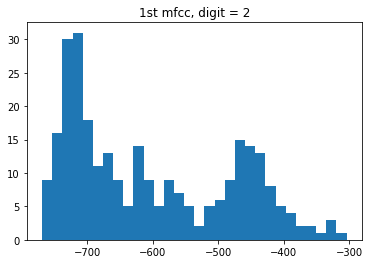

In [ ]:
plt.hist(mfcc2_0_new, bins=30)
plt.title("1st mfcc, digit = 2")

Text(0.5, 1.0, '2nd mfcc, digit = 2')

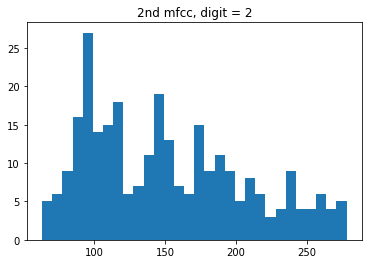

In [ ]:
plt.hist(mfcc2_1_new, bins=30)
plt.title("2nd mfcc, digit = 2")

Text(0.5, 1.0, '1st mfcc, digit = 8')

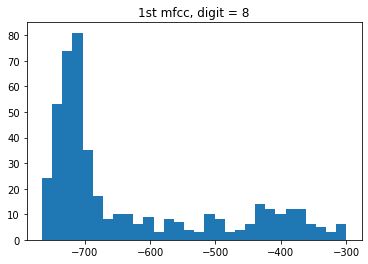

In [ ]:
plt.hist(mfcc8_0_new, bins=30)
plt.title("1st mfcc, digit = 8")

Text(0.5, 1.0, '2nd mfcc, digit = 8')

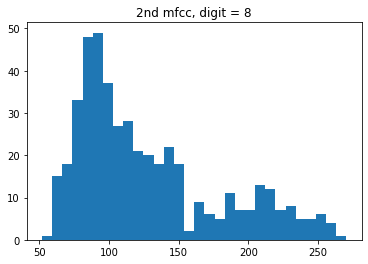

In [ ]:
plt.hist(mfcc8_1_new, bins=30)
plt.title("2nd mfcc, digit = 8")

In [ ]:
#we take 2 samples for every number
#we compute mfcs using the librosa.feature.melspectrogram

mfcc2 = []
mfsc2 = []
mfcc8 = []
mfsc8 = []
  
counter1 = 0
counter2 = 0
for i in range(len(ids)):
    if (ids[i]=='two' and counter1 < 2):
        counter1 = counter1 + 1
        mfcc2.append(librosa.feature.mfcc(wavfiles[i], Fs, n_fft=window, hop_length=window - step, n_mfcc=13))
        mfsc2.append(librosa.feature.melspectrogram(wavfiles[i], Fs, n_fft=window, hop_length=window - step, n_mels=13))
    if (ids[i]=='eight' and counter2 < 2):
        counter2 = counter2 + 1
        mfcc8.append(librosa.feature.mfcc(wavfiles[i], Fs, n_fft=window, hop_length=window - step, n_mfcc=13))
        mfsc8.append(librosa.feature.melspectrogram(wavfiles[i], Fs, n_fft=window, hop_length=window - step, n_mels=13))
    if (counter1>=2 and counter2>=2):
        break

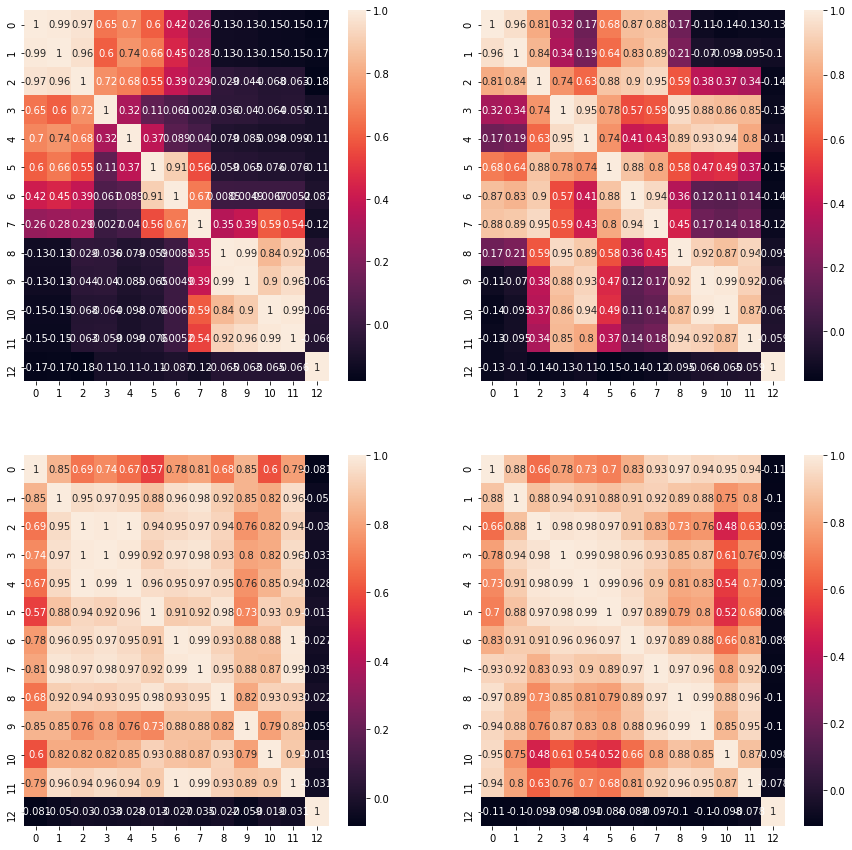

In [ ]:
#for the diagrams we use the guide from here : https://datatofish.com/correlation-matrix-pandas/

df_mfsc2_0 = pd.DataFrame(mfsc2[0].T)
corr_mfsc2_0 = df_mfsc2_0.corr()

df_mfsc2_1 = pd.DataFrame(mfsc2[1].T)
corr_mfsc2_1 = df_mfsc2_1.corr()

df_mfsc8_0 = pd.DataFrame(mfsc8[0].T)
corr_mfsc8_0 = df_mfsc8_0.corr()

df_mfsc8_1 = pd.DataFrame(mfsc8[1].T)
corr_mfsc8_1 = df_mfsc8_1.corr()


fig = plt.figure(figsize=(15,15))

fig.add_subplot(2, 2, 1)
sn.heatmap(corr_mfsc2_0, annot=True)
#plt.show()

fig.add_subplot(2, 2, 2)
sn.heatmap(corr_mfsc2_1, annot=True)
#plt.show()

fig.add_subplot(2, 2, 3)
sn.heatmap(corr_mfsc8_0, annot=True)
#plt.show()

fig.add_subplot(2, 2, 4)
sn.heatmap(corr_mfsc8_1, annot=True)
plt.show()

Όμοια για τα mfccs :

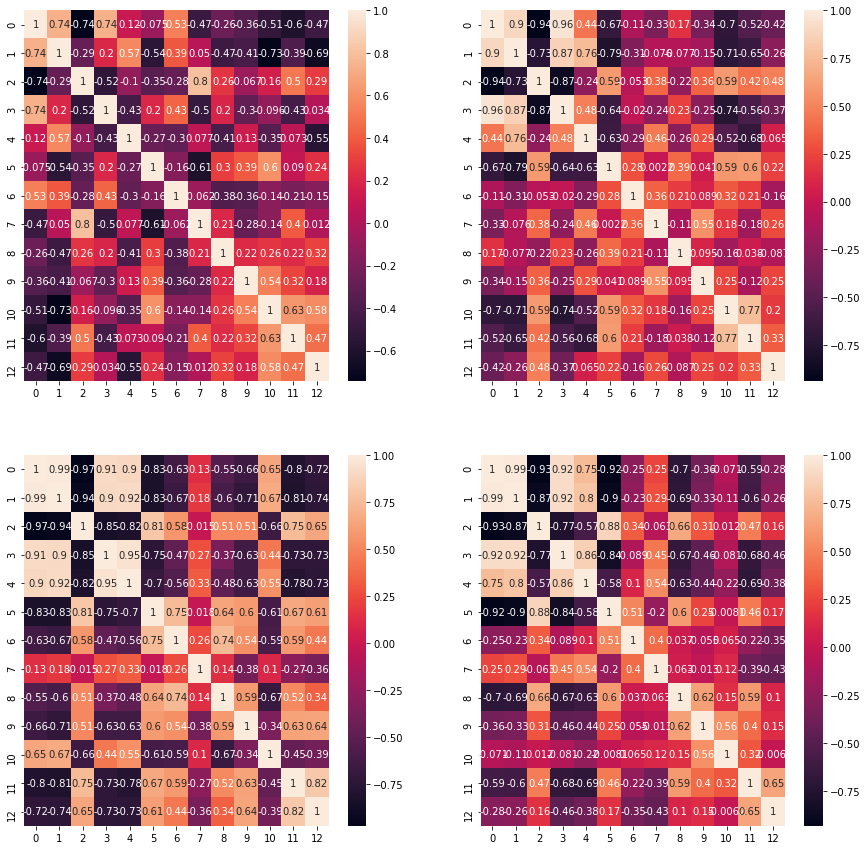

In [ ]:
df_mfcc2_0 = pd.DataFrame(mfcc2[0].T)
corr_mfcc2_0 = df_mfcc2_0.corr()

df_mfcc2_1 = pd.DataFrame(mfcc2[1].T)
corr_mfcc2_1 = df_mfcc2_1.corr()

df_mfcc8_0 = pd.DataFrame(mfcc8[0].T)
corr_mfcc8_0 = df_mfcc8_0.corr()

df_mfcc8_1 = pd.DataFrame(mfcc8[1].T)
corr_mfcc8_1 = df_mfcc8_1.corr()


fig = plt.figure(figsize=(15,15))

fig.add_subplot(2, 2, 1)
sn.heatmap(corr_mfcc2_0, annot=True)
#plt.show()

fig.add_subplot(2, 2, 2)
sn.heatmap(corr_mfcc2_1, annot=True)
#plt.show()

fig.add_subplot(2, 2, 3)
sn.heatmap(corr_mfcc8_0, annot=True)
#plt.show()

fig.add_subplot(2, 2, 4)
sn.heatmap(corr_mfcc8_1, annot=True)
plt.show()

## **Βήμα 5 : Scatter Διαγράμματα**


In [ ]:
# we combine our characteristics into one feature vector
# of the mean/std of all windows

features_for_all_windows = []

for rec in range(len(wavfiles)):
  rec_mfcc = frames[rec]
  rec_deltas = delta[rec]
  rec_delta_deltas = delta_deltas[rec]
  rec_features = np.concatenate((rec_mfcc, rec_deltas, rec_delta_deltas), axis=0)
  features_for_all_windows.append(rec_features)

feature_means = []
#we save the mean value for all the windows of every wav file
for rec in range(len(features_for_all_windows)):
  features = features_for_all_windows[rec]
  feature_means.append(np.mean(features, axis=1))

feature_stds = []
#we save the std value for all the windows of every wav file
for rec in range(len(features_for_all_windows)):
  features = features_for_all_windows[rec]
  feature_stds.append(np.std(features, axis=1))

common_features = []
#we need a common list for the mean and std values 
for rec in range(len(features_for_all_windows)):
  temp = np.concatenate((feature_means[rec], feature_stds[rec]), axis=0)
  common_features.append(temp)

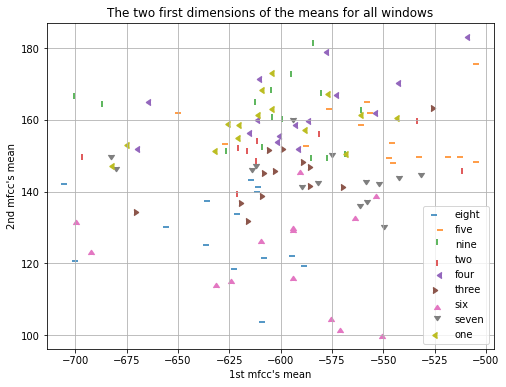

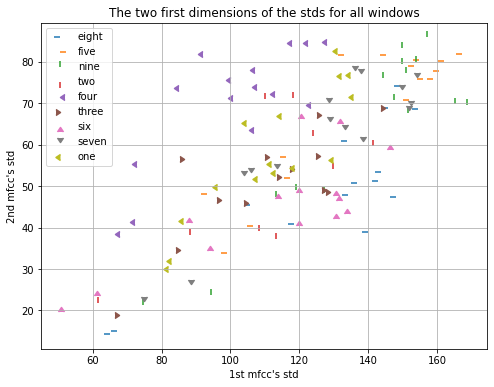

In [ ]:
# We scatter our datas' first and second dimensions of our aggregating vectors

markers = np.arange(9)

m = 0
fig = plt.figure(num=1, figsize=(8, 6))
ax = plt.subplot()
plt.grid(True)
plt.title("The two first dimensions of the means for all windows")
ax.set_xlabel("1st mfcc's mean")
ax.set_ylabel("2nd mfcc's mean")

labels = set(ids)
for label in labels:
  feat_0 = []
  feat_1 = []
  # get all feautres from vectors of label
  for i in range(len(feature_means)):
    if ids[i] == label:
      feat_0.append(feature_means[i][0])
      feat_1.append(feature_means[i][1])
  # and we scatter them
  plt.scatter(feat_0, feat_1, label=label, marker=markers[m])
  m = m + 1
  
ax.legend()
plt.show()

m = 0
fig = plt.figure(num=2, figsize=(8, 6))
ax = plt.subplot()
plt.grid(True)
plt.title("The two first dimensions of the stds for all windows")
ax.set_xlabel("1st mfcc's std")
ax.set_ylabel("2nd mfcc's std")

labels = set(ids)
for label in labels:
  feat_0 = []
  feat_1 = []
  # get all feautres from vectors of label
  for i in range(len(feature_stds)):
    if ids[i] == label:
      feat_0.append(feature_stds[i][0])
      feat_1.append(feature_stds[i][1])
  # and we scatter them
  plt.scatter(feat_0, feat_1, label=label, marker=markers[m])
  m = m + 1
  
ax.legend()
plt.show()

Παρατηρούμε ότι, ως προς τις πρώτες δύο διαστάσεις τουλάχιστον, τα διανύσματα μας είναι αρκετά χαοτικά. Αυτό συμβαίνει αφενός διότι έχουμε διαλέξει πολύ μικρό αριθμό διαστάσεων κατά την αναπαράσταση στο επίπεδο και αφετέρου διότι παίρνοντας μέσες τιμές και τυπικές αποκλίσεις για όλα τα παράθυρα σε κάθε εκφώνηση δεν λαμβάνουμε καθόλου υπόψη μας την χρονική συσχέτιση των δεδομένων μας.

## **Βήμα 6 : PCA**

Θα εφαρμόσουμε PCA ώστε αυτή την φορά να απεικονίσουμε τα διανύσματα μέσης τιμής και τυπικής απόκλισης σε έναν διαφορετικό υπόχωρο, ώστε να έχουμε καλύτερη αποτύπωση της κατανομής στις πολλές διαστάσεις.

Percentage in 2 components of means:  0.810002412609621
Percentage in 3 components of means:  0.8890615125150323


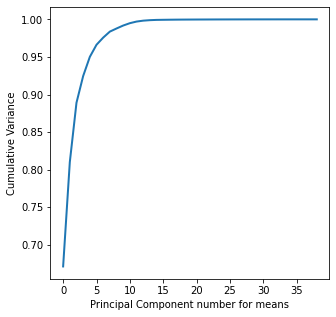

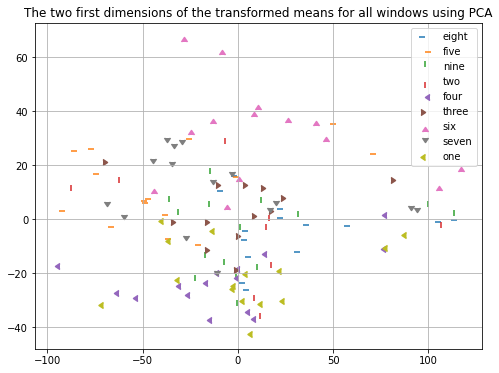

Percentage in 2 components of stds:  0.8392611153551355
Percentage in 3 components of stds:  0.89266259613568


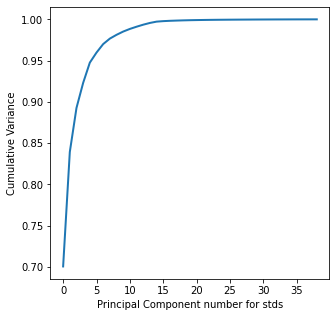

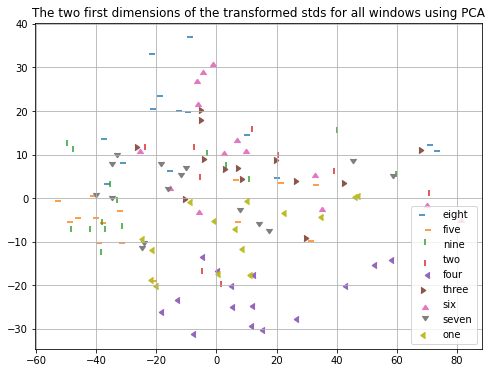

In [ ]:
# first the means

pca = PCA()
pca.fit(feature_means)
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print("Percentage in 2 components of means: ", cum_evar[1])
print("Percentage in 3 components of means: ", cum_evar[2])
plt.figure(1, figsize=(5, 5))
plt.xlabel("Principal Component number for means")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

pca = PCA(n_components=2)
pca_means = pca.fit_transform(feature_means)

markers = np.arange(9)

m = 0
fig = plt.figure(num=2, figsize=(8, 6))
ax = plt.subplot()
plt.grid(True)
plt.title("The two first dimensions of the transformed means for all windows using PCA")

labels = set(ids)
for label in labels:
  feat_0 = []
  feat_1 = []
  # get all feautres from vectors of label
  for i in range(len(pca_means)):
    if ids[i] == label:
      feat_0.append(pca_means[i][0])
      feat_1.append(pca_means[i][1])
  # and we scatter them
  plt.scatter(feat_0, feat_1, label=label, marker=markers[m])
  m = m + 1
  
ax.legend()
plt.show()

# secondly the stds

pca = PCA()
pca.fit(feature_stds)
evar = pca.explained_variance_ratio_
cum_evar = np.cumsum(evar)
print("Percentage in 2 components of stds: ", cum_evar[1])
print("Percentage in 3 components of stds: ", cum_evar[2])
plt.figure(3, figsize=(5, 5))
plt.xlabel("Principal Component number for stds")
plt.ylabel('Cumulative Variance')
plt.plot(cum_evar, linewidth=2)
plt.show()

pca = PCA(n_components=2)
pca_stds = pca.fit_transform(feature_stds)

markers = np.arange(9)

m = 0
fig = plt.figure(num=4, figsize=(8, 6))
ax = plt.subplot()
plt.grid(True)
plt.title("The two first dimensions of the transformed stds for all windows using PCA")

labels = set(ids)
for label in labels:
  feat_0 = []
  feat_1 = []
  # get all feautres from vectors of label
  for i in range(len(pca_stds)):
    if ids[i] == label:
      feat_0.append(pca_stds[i][0])
      feat_1.append(pca_stds[i][1])
  # and we scatter them
  plt.scatter(feat_0, feat_1, label=label, marker=markers[m])
  m = m + 1
  
ax.legend()
plt.show()

Παρατηρούμε ότι και στον νέο χώρο τα δεδομένα συνεχίζουν να είναι αρκετά χαοτικά και οι κατανομές πολύ δυσδιάκριτες. Αυτό είναι αναμενόμενο αν δούμε τις καμπύλες διάστασης-πληροφοριακού περιεχομένου που δίνει η pca για 2 μόνο συνιστώσες. Θα προσπαθήσουμε άλλη μία φορά στις 3 διαστάσεις.

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


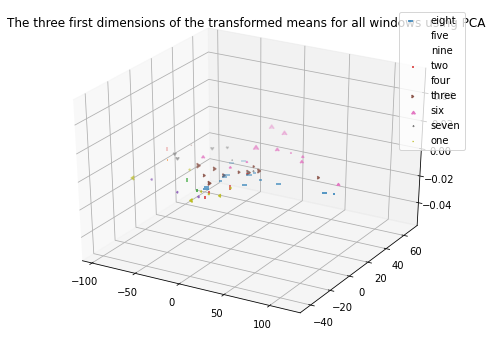

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


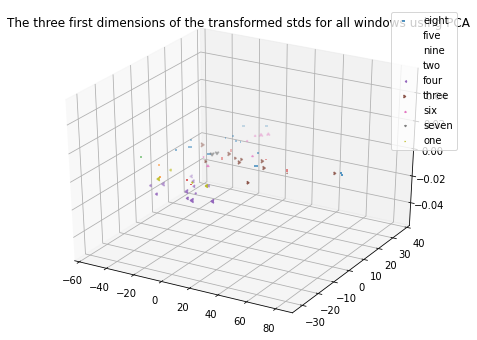

In [ ]:
pca = PCA(n_components=3)
pca_means = pca.fit_transform(feature_means)

markers = np.arange(9)

m = 0
fig = plt.figure(num=1, figsize=(8, 6))
ax = plt.subplot(projection='3d')
plt.grid(True)
plt.title("The three first dimensions of the transformed means for all windows using PCA")

labels = set(ids)
for label in labels:
  feat_0 = []
  feat_1 = []
  feat_2 = []
  # get all feautres from vectors of label
  for i in range(len(pca_means)):
    if ids[i] == label:
      feat_0.append(pca_means[i][0])
      feat_1.append(pca_means[i][1])
      feat_2.append(pca_means[i][2])
  # and we scatter them
  plt.scatter(feat_0, feat_1, feat_2, label=label, marker=markers[m])
  m = m + 1
  
ax.legend()
plt.show()


pca = PCA(n_components=3)
pca_stds = pca.fit_transform(feature_stds)

markers = np.arange(9)

m = 0
fig = plt.figure(num=4, figsize=(8, 6))
ax = plt.subplot(projection='3d')
plt.grid(True)
plt.title("The three first dimensions of the transformed stds for all windows using PCA")

labels = set(ids)
for label in labels:
  feat_0 = []
  feat_1 = []
  feat_2 = []
  # get all feautres from vectors of label
  for i in range(len(pca_stds)):
    if ids[i] == label:
      feat_0.append(pca_stds[i][0])
      feat_1.append(pca_stds[i][1])
      feat_2.append(pca_stds[i][2])
  # and we scatter them
  plt.scatter(feat_0, feat_1, feat_2, label=label, marker=markers[m])
  m = m + 1
  
ax.legend()
plt.show()

Επαναλαμβάνουμε την απεικόνιση με pca σε 2 και 3 διστάσεις αλλά αυτή την φορά στα συνδυασμένα,με concatenation, διανύσματα μέσης τιμής και τυπικής απόκλισης.

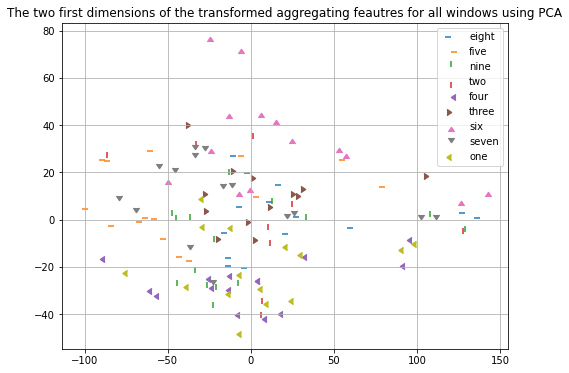

/usr/local/lib/python3.6/dist-packages/matplotlib/collections.py:885: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


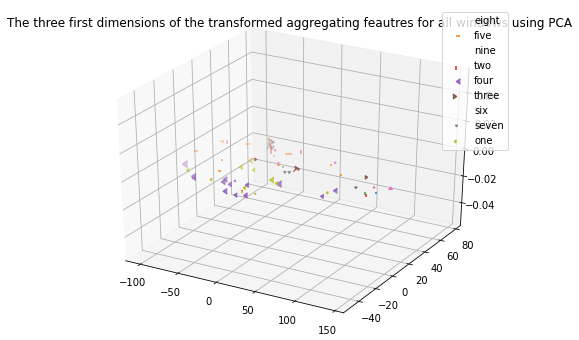

In [ ]:
pca = PCA(n_components=2)
pca_common = pca.fit_transform(common_features)

markers = np.arange(9)

m = 0
fig = plt.figure(num=1, figsize=(8, 6))
ax = plt.subplot()
plt.grid(True)
plt.title("The two first dimensions of the transformed aggregating feautres for all windows using PCA")

labels = set(ids)
for label in labels:
  feat_0 = []
  feat_1 = []
  # get all feautres from vectors of label
  for i in range(len(pca_common)):
    if ids[i] == label:
      feat_0.append(pca_common[i][0])
      feat_1.append(pca_common[i][1])
  # and we scatter them
  plt.scatter(feat_0, feat_1, label=label, marker=markers[m])
  m = m + 1
  
ax.legend()
plt.show()


pca = PCA(n_components=3)
pca_common = pca.fit_transform(common_features)

markers = np.arange(9)

m = 0
fig = plt.figure(num=2, figsize=(8, 6))
ax = plt.subplot(projection='3d')
plt.grid(True)
plt.title("The three first dimensions of the transformed aggregating feautres for all windows using PCA")

labels = set(ids)
for label in labels:
  feat_0 = []
  feat_1 = []
  feat_2 = []
  # get all feautres from vectors of label
  for i in range(len(pca_common)):
    if ids[i] == label:
      feat_0.append(pca_common[i][0])
      feat_1.append(pca_common[i][1])
      feat_2.append(pca_common[i][2])
  # and we scatter them
  plt.scatter(feat_0, feat_1, feat_2, label=label, marker=markers[m])
  m = m + 1
  
ax.legend()
plt.show()

Παρατηρούμε ότι και με συνδυασμένο τρόπο αυτά τα δεδομένα δεν μπορούν να απεικονιστούν είτε στις 2 είτε στις 3 διαστάσεις με κάποιον τρόπο που να είναι φανερή η υποκείμενη κατανομή τους.

##**Βήμα 7 : Classification**

In [ ]:
from sklearn.base import BaseEstimator, ClassifierMixin
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import zero_one_loss
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
import scipy.stats
import sklearn.naive_bayes as sk
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC

#we convert the ids to int labels for the digits we have

digits = {
  'one': 1,
  'two': 2,
  'three': 3,
  'four': 4,
  'five': 5,
  'six': 6,
  'seven': 7,
  'eight': 8,
  'nine': 9
}

labels = [digits[i] for i in ids]

In [ ]:
print(labels)

[7, 1, 9, 8, 5, 2, 3, 5, 6, 3, 7, 2, 9, 5, 5, 4, 8, 4, 4, 3, 8, 2, 8, 6, 4, 7, 8, 8, 5, 9, 2, 8, 1, 6, 7, 3, 4, 7, 6, 4, 6, 2, 5, 2, 3, 4, 1, 2, 7, 5, 2, 1, 6, 6, 7, 9, 3, 9, 3, 8, 1, 8, 7, 2, 9, 7, 6, 5, 6, 1, 2, 9, 1, 8, 7, 8, 3, 3, 4, 7, 9, 8, 7, 8, 3, 5, 7, 5, 3, 9, 1, 1, 1, 2, 3, 4, 9, 9, 2, 4, 9, 7, 6, 5, 3, 6, 4, 6, 4, 8, 7, 9, 1, 3, 6, 1, 1, 5, 5, 4, 1, 5, 4, 1, 4, 3, 2, 2, 9, 2, 9, 5, 6]


In [ ]:
from sklearn.model_selection import train_test_split

common_features = np.asarray(common_features)
labels = np.asarray(labels)
train, test, train_labels, test_labels = train_test_split(common_features, labels, test_size=0.3)

In [ ]:
print(test.shape)
print(train.shape)
print(test_labels.shape)
print(train_labels.shape)

(40, 78)
(93, 78)
(40,)
(93,)


In [ ]:
#we have to normalize the data firstly 
#we use a standard scaler for that

scaler = StandardScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test) 

Χρησιμοποιούμε τους κώδικες για τον custom classifier που υλοποιήσαμε στο πρώτο εργαστήριο :

In [ ]:
def calculate_priors(X, y):
    """Return the a-priori probabilities for every class
    Args:
        X (np.ndarray): Digits data (nsamples x nfeatures)
        y (np.ndarray): Labels for dataset (nsamples)
    Returns:
        (np.ndarray): (n_classes) Prior probabilities for every class
    """
    classes = set(y)
    priors = np.zeros(len(classes))
    i = 0
    for cl in classes:
        priors[i] = len(y[y == cl])
        i = i + 1
    return priors / len(y)

In [ ]:
class CustomNBClassifier(BaseEstimator, ClassifierMixin):
    """Custom implementation Naive Bayes classifier"""

    def __init__(self, use_unit_variance=False):
        self.means = None
        self.stds = None
        self.priors = None
        self.use_unit_variance = use_unit_variance


    def fit(self, X, y):
        """
        This should fit classifier. All the "work" should be done here.
        Calculates Naive Bayesian Model parameters based on the
        feature values in X for each class.
        We preserve for every class and feature
        -means : (n_classes)x(x_features)
        -stds (standard deviations) : (n_classes)x(x_features)
        and for every class
        -priors : (n_classes)
        fit always returns self.
        """
        # For our NB model to work we make the following assumptions
        # -for every class c p(x|c) is a normal distribution (μ, σ^2) pdf
        # -all classes c are independent
        # -we assume that the samples of X are identically independently distributed
        # -for every class the parameters (μ, σ^2) are fixed
        
        # For the Naive assumption
        # -all the features are independent for every class
        # This means that p(x|class) = Π{p(x[f]|class) : for every feature f}
        
        [n_samples, n_features] = X.shape
        classes = set(y)
        #print(classes)
        n_classes = len(classes)
        self.means = np.zeros([n_classes, n_features])        
        self.stds = np.ones([n_classes, n_features])
        
        # First we calculate μ for every class and every feature
        # In this case μ is the mean of the vectors of each class
        for cl in range(n_classes):
            class_samples = X[y == cl+1]
            self.means[cl] = class_samples.mean(axis=0) # we use axis=0 to calculate mean in the vertical dimension
        #print(self.means)
        # Then we calculate σ^2 for every class and every feature
        # In this case σ^2 for each class is the Mean squared error
        small_std = 1e-5 # in case variance is zero
        if self.use_unit_variance != True:
            for cl in range(n_classes):
                class_samples = X[y == cl+1]
                self.stds[cl] = class_samples.std(axis=0) + small_std # we use axis=0 to calculate std in the vertical dimension
        # Finally we calculate the classes' priors
        self.priors = calculate_priors(X, y)        
        return self
    
    
    def predict(self, X):
        """
        Make predictions for X based on the
        self.mean
        self.variances
        self.priors
        """
        n_samples = len(X)
        [n_classes, n_features] = self.means.shape
        predictions = np.zeros(n_samples)
                
        # We will find the class with the highest a-posteriori value
        # for every class i.e. prediction(x) = argmax{N(μ, σ^2)(x)*p(class)}
        # For computation reason we use log function
        # prediction(x) = argmax{N(μ, σ^2)(x)*p(class)} = argmax{Σlog(pdf(x[features]|class))+log(prior(class)}
        for i in range(n_samples):
            a_posteriories = np.zeros(n_classes)
            for cl in range(n_classes):
                vector_logpdf = scipy.stats.norm.logpdf(X[i], loc=self.means[cl], scale=self.stds[cl])
                a_post = np.sum(vector_logpdf) + np.log(self.priors[cl])
                a_posteriories[cl] = a_post
            predictions[i] = np.argmax(a_posteriories)+1
        return predictions
    

    def score(self, X, y):
        """
        Return accuracy score on the predictions
        for X based on ground truth y
        """
        predictions = self.predict(X)
        return 1-zero_one_loss(y, predictions)


In [ ]:
custom = CustomNBClassifier()
#print(custom.predict(test))
custom.fit(train, train_labels)
p = custom.score(test, test_labels)
print("The success rate of our NB classifier's predictions is", p * 100, "%")

The success rate of our NB classifier's predictions is 60.0 %


In [ ]:
import sklearn.naive_bayes as sk

# We can compare it to the scikit learn implementation
nb = sk.GaussianNB()
nb.fit(train, train_labels)

print("The success rate of the library's NB classifier's predictions is", nb.score(test, test_labels) * 100, "%") 

The success rate of the library's NB classifier's predictions is 60.0 %


In [ ]:
from sklearn.neighbors import KNeighborsClassifier

nn = KNeighborsClassifier(n_neighbors = 5)
nn.fit(train, train_labels)

print("The success rate of the 5NN classifier's predictions is", nn.score(test, test_labels) * 100, "%") 

The success rate of the 5NN classifier's predictions is 57.49999999999999 %


In [ ]:
from sklearn.svm import SVC

svm = SVC(kernel='rbf')
svm.fit(train, train_labels)

print("The success rate of the SVM classifier's predictions is", svm.score(test, test_labels) * 100, "%") 

The success rate of the SVM classifier's predictions is 57.49999999999999 %


In [ ]:
from sklearn.neural_network import MLPClassifier

mlp = MLPClassifier(max_iter=1000)
mlp.fit(train, train_labels)

print("The success rate of the MLP classifier's predictions is", mlp.score(test, test_labels) * 100, "%") 

The success rate of the MLP classifier's predictions is 67.5 %


Παραπάνω κάναμε ταξινομήση των data μας με 5 επιθυμητούς ταξινομητές. Όπως βλέπουμε, τα αποτελέσματα που παίρνουμε είναι όλα αρκετά μικρά σε ποσοστά και καταλήγουμε στο εύλογο συμπέρασμα ότι τα δεδομένα που χρησιμοποίησαμε ως training data δεν είναι ικανά να μας παρέχουν σημαντικές διαφοροποιήσεις των αποτελεσμάτων για να επιτύχουμε μια επαρκή ταξινόμηση.

## **Βήμα 8 : RNN-LSTM-GRU**

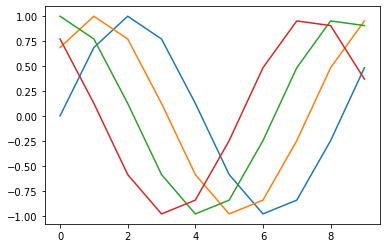

In [ ]:
import math

# Creating the Data

f = 40.0
distance = 0.003
w = 2*(math.pi)*f

n_samples = 100
input = []
output = []

for s in range(n_samples):
  sin_samples = []
  cos_samples = []
  for i in range(10):
    sin_samples.append(math.sin(w*distance*(i + s)))
    cos_samples.append(math.sin(math.pi/2 - w*distance*(i + s)))
  input.append(sin_samples)
  output.append(cos_samples)


plt.plot(input[0])
plt.plot(input[1])
plt.plot(input[2])
plt.plot(input[3])

In [ ]:
import torch
from torch import nn as nn
from torch import optim

# Transforming the data into appropriate form

batch_size = 80
seq_len = 10
fragment_size = 1

output_dimension = 1
number_of_layers = 1

# create the features in a numpy array of desired size
sin_features = np.zeros((n_samples, seq_len, fragment_size), dtype=np.float32)
cos_features = np.zeros((n_samples, seq_len, fragment_size), dtype=np.float32)
for i in range(n_samples):
  for j in range(seq_len):
      sin_features[i][j][0] = input[i][j]
      cos_features[i][j][0] = output[i][j]
# turn them into two tensors
input_set = torch.from_numpy(sin_features).view((n_samples, seq_len, fragment_size))
target_set = torch.from_numpy(cos_features).view((n_samples, seq_len, fragment_size))

# we will keep 80 of the 100 pairs of sequences as training set and 20 of them for test
train_input_tensor = input_set[:batch_size]
train_target_tensor = target_set[:batch_size]

test_input_tensor = input_set[batch_size - 1:-1]
test_target_tensor = target_set[batch_size - 1:-1]

In [ ]:
# Training a simple rnn

model = nn.RNN(input_size=fragment_size, hidden_size=output_dimension, batch_first=True)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.1)

epochs = 2000
for epoch in range(epochs):
  optimizer.zero_grad()
  out, _ = model(train_input_tensor)
  loss = loss_function(out, train_target_tensor)
  loss.backward()
  optimizer.step()
  if (epoch%100==0):
    print("epoch : ", epoch, ", loss = ", loss.item())

out_rnn, _ = model(test_input_tensor)

epoch :  0 , loss =  0.8847302198410034
epoch :  100 , loss =  0.4544160068035126
epoch :  200 , loss =  0.4544139504432678
epoch :  300 , loss =  0.4544139802455902
epoch :  400 , loss =  0.45441392064094543
epoch :  500 , loss =  0.45441392064094543
epoch :  600 , loss =  0.45441392064094543
epoch :  700 , loss =  0.4544139504432678
epoch :  800 , loss =  0.45441392064094543
epoch :  900 , loss =  0.45441392064094543
epoch :  1000 , loss =  0.4544139504432678
epoch :  1100 , loss =  0.45441392064094543
epoch :  1200 , loss =  0.45441392064094543
epoch :  1300 , loss =  0.4544139504432678
epoch :  1400 , loss =  0.4544139802455902
epoch :  1500 , loss =  0.4544139504432678
epoch :  1600 , loss =  0.45441392064094543
epoch :  1700 , loss =  0.45441392064094543
epoch :  1800 , loss =  0.45441392064094543
epoch :  1900 , loss =  0.45441392064094543


In [ ]:
# Training a simple lstm

model = nn.LSTM(input_size=fragment_size, hidden_size=output_dimension, batch_first=True)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 2000
for epoch in range(epochs):
  optimizer.zero_grad()
  out, _ = model(train_input_tensor)
  loss = loss_function(out, train_target_tensor)
  loss.backward()
  optimizer.step()
  if (epoch%100==0):
    print("epoch : ", epoch, ", loss = ", loss.item())

out_lstm, _ = model(test_input_tensor)

epoch :  0 , loss =  0.5037835836410522
epoch :  100 , loss =  0.3925892114639282
epoch :  200 , loss =  0.1617979258298874
epoch :  300 , loss =  0.13113649189472198
epoch :  400 , loss =  0.12222286313772202
epoch :  500 , loss =  0.11708446592092514
epoch :  600 , loss =  0.11371287703514099
epoch :  700 , loss =  0.11140551418066025
epoch :  800 , loss =  0.10974635183811188
epoch :  900 , loss =  0.10848887264728546
epoch :  1000 , loss =  0.1074899286031723
epoch :  1100 , loss =  0.10666793584823608
epoch :  1200 , loss =  0.10597570240497589
epoch :  1300 , loss =  0.10538316518068314
epoch :  1400 , loss =  0.10486851632595062
epoch :  1500 , loss =  0.1044146940112114
epoch :  1600 , loss =  0.10400798916816711
epoch :  1700 , loss =  0.10363772511482239
epoch :  1800 , loss =  0.10329600423574448
epoch :  1900 , loss =  0.10297746956348419


In [ ]:
# Training a simple gru

model = nn.GRU(input_size=fragment_size, hidden_size=output_dimension, batch_first=True)

loss_function = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

epochs = 2000
for epoch in range(epochs):
  optimizer.zero_grad()
  out, _ = model(train_input_tensor)
  loss = loss_function(out, train_target_tensor)
  loss.backward()
  optimizer.step()
  if (epoch%100==0):
    print("epoch : ", epoch, ", loss = ", loss.item())

out_gru, _ = model(test_input_tensor)

epoch :  0 , loss =  0.7237746715545654
epoch :  100 , loss =  0.3641842305660248
epoch :  200 , loss =  0.19493669271469116
epoch :  300 , loss =  0.1846017688512802
epoch :  400 , loss =  0.17842574417591095
epoch :  500 , loss =  0.17428874969482422
epoch :  600 , loss =  0.1711382418870926
epoch :  700 , loss =  0.1677008867263794
epoch :  800 , loss =  0.16504709422588348
epoch :  900 , loss =  0.16306327283382416
epoch :  1000 , loss =  0.16119535267353058
epoch :  1100 , loss =  0.1589289903640747
epoch :  1200 , loss =  0.15491485595703125
epoch :  1300 , loss =  0.14260588586330414
epoch :  1400 , loss =  0.1264495998620987
epoch :  1500 , loss =  0.118730828166008
epoch :  1600 , loss =  0.11513623595237732
epoch :  1700 , loss =  0.11319364607334137
epoch :  1800 , loss =  0.11134283989667892
epoch :  1900 , loss =  0.10873226076364517


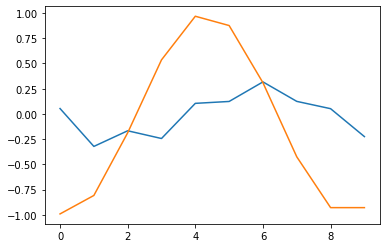

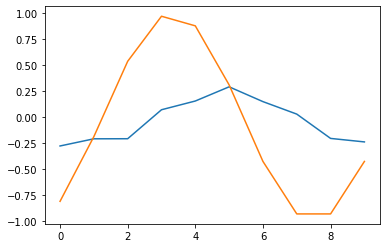

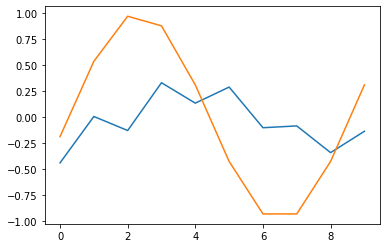

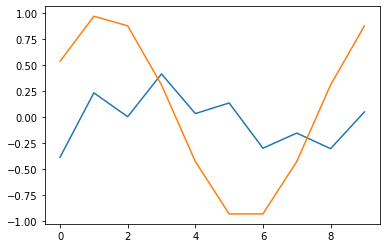

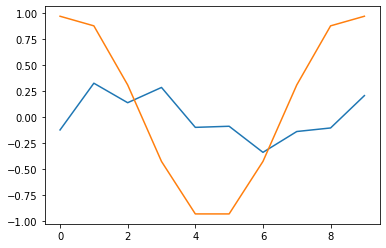

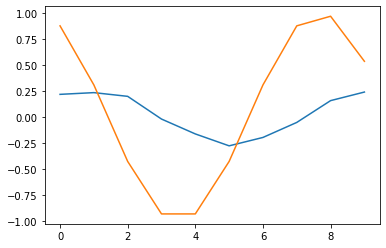

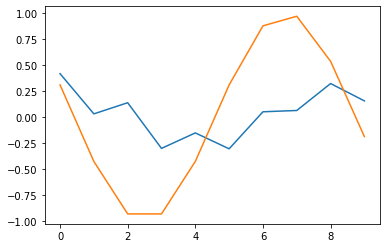

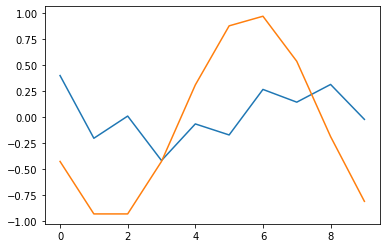

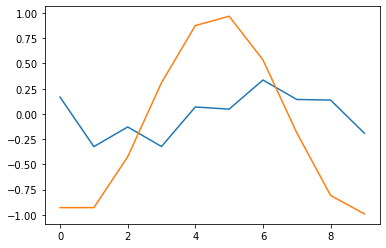

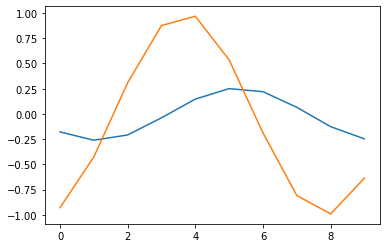

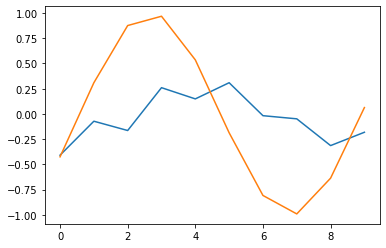

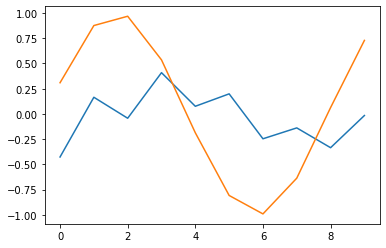

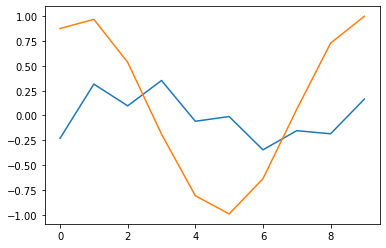

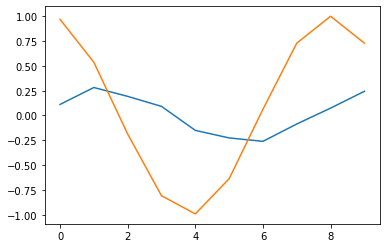

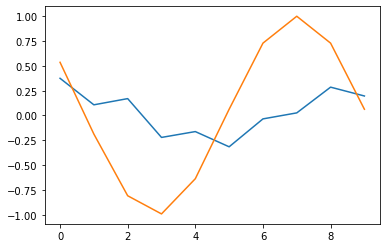

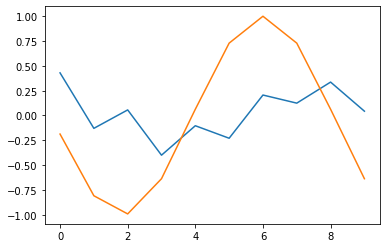

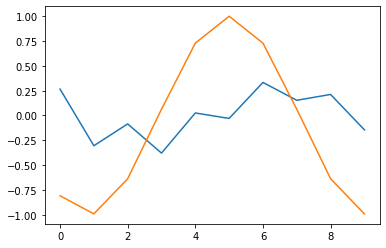

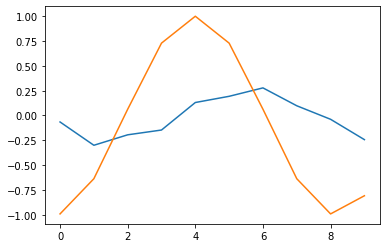

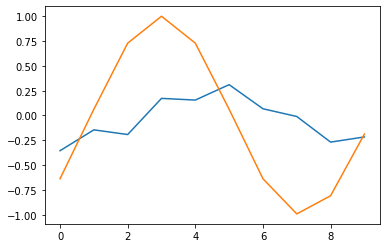

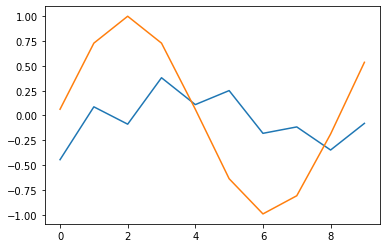

In [ ]:
# testing rnn

for i in range(n_samples - batch_size):
  plt.figure()
  res = out_rnn[i].detach().view(-1).numpy()
  tar = test_target_tensor[i].detach().view(-1).numpy()

  plt.plot(res)
  plt.plot(tar)

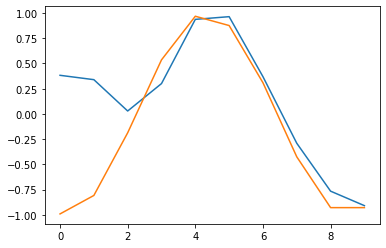

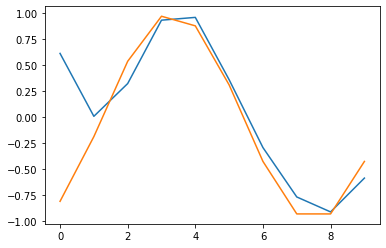

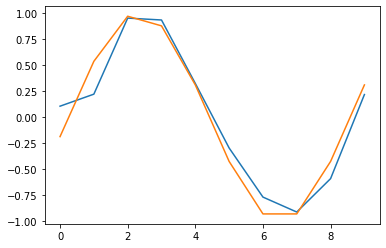

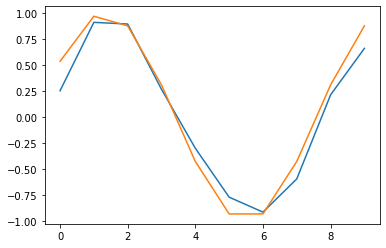

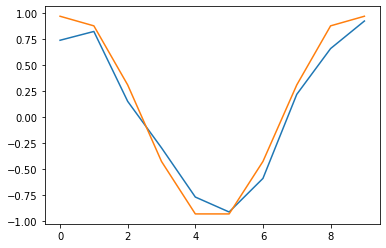

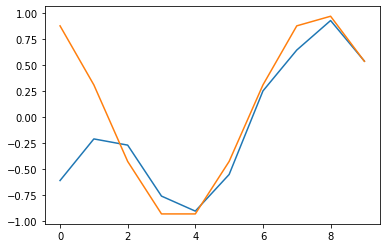

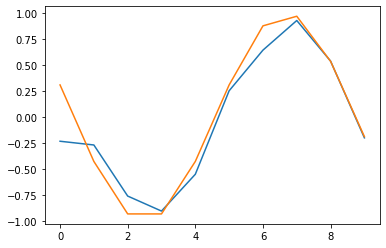

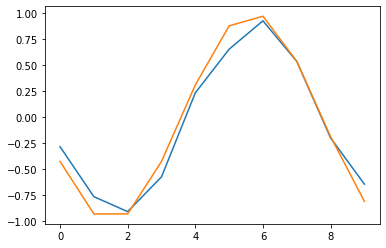

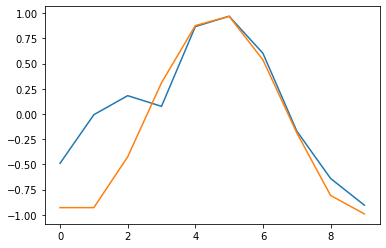

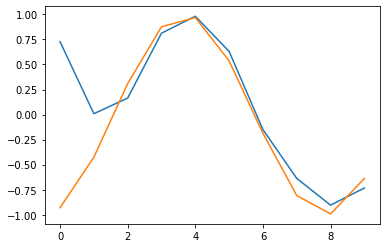

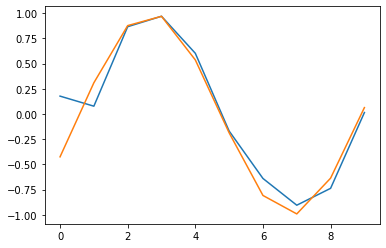

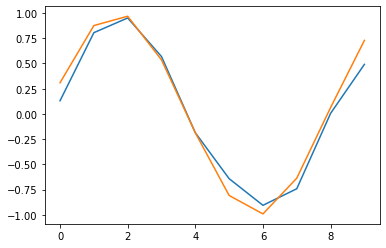

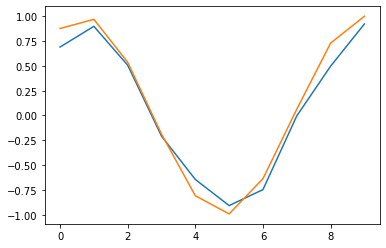

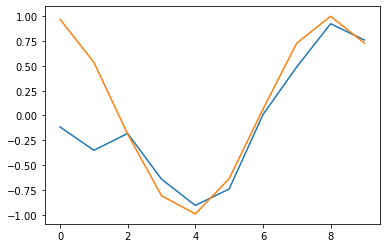

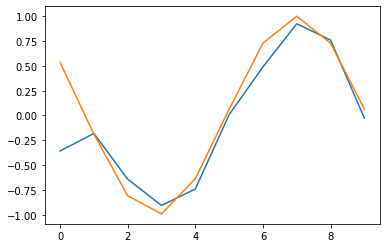

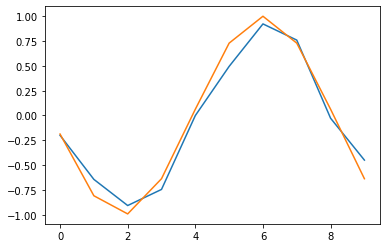

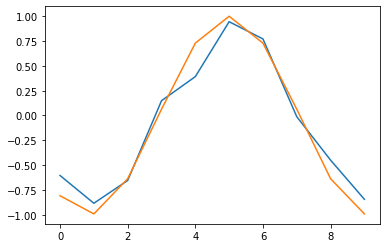

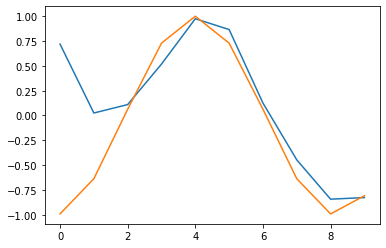

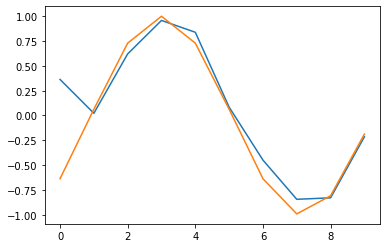

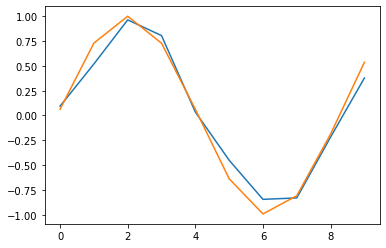

In [ ]:
# testing lstm

for i in range(n_samples - batch_size):
  plt.figure()
  res = out_lstm[i].detach().view(-1).numpy()
  tar = test_target_tensor[i].detach().view(-1).numpy()

  plt.plot(res)
  plt.plot(tar)

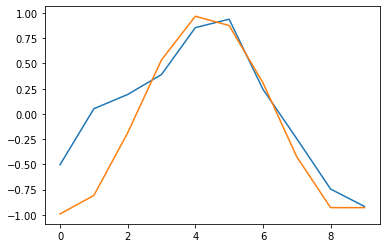

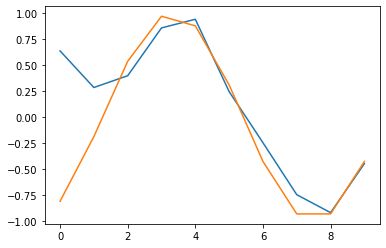

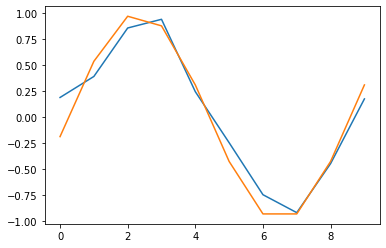

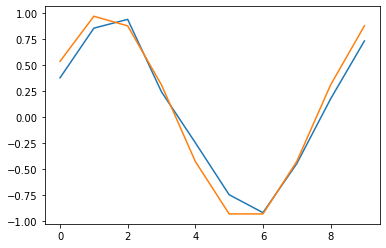

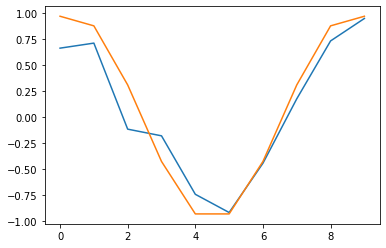

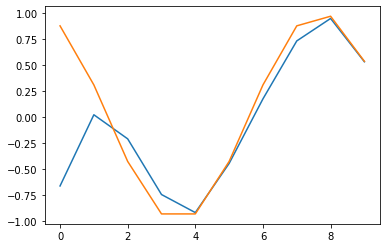

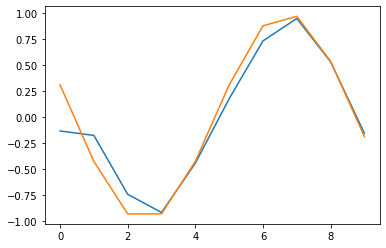

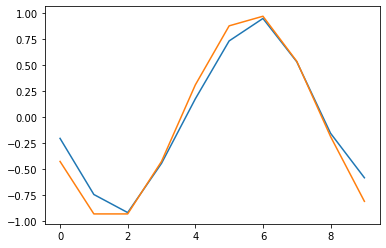

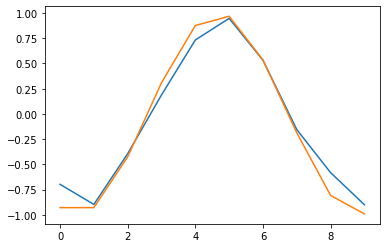

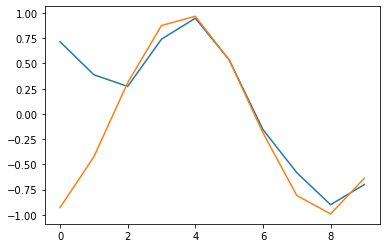

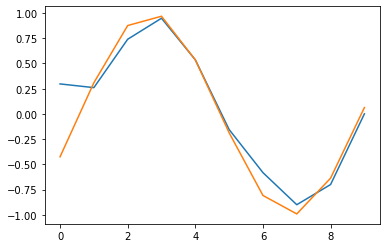

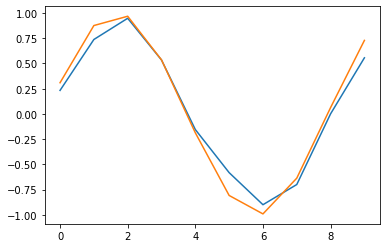

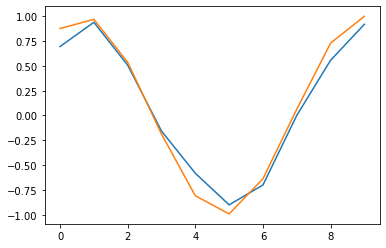

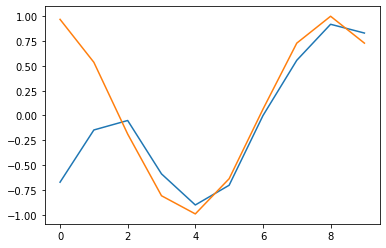

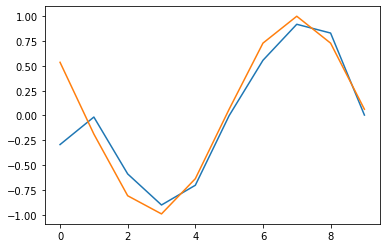

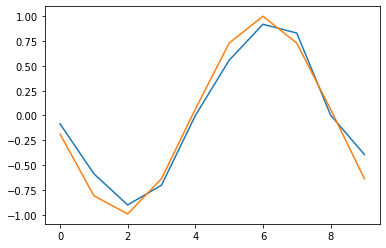

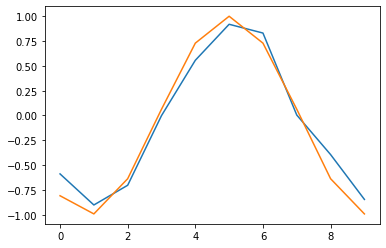

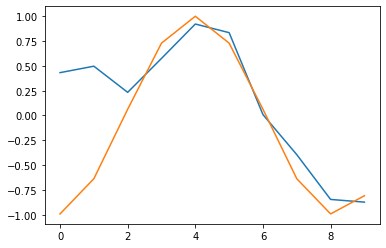

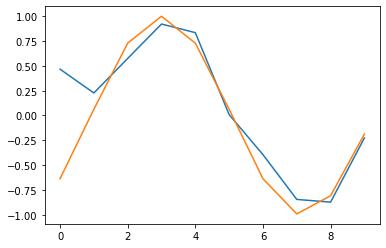

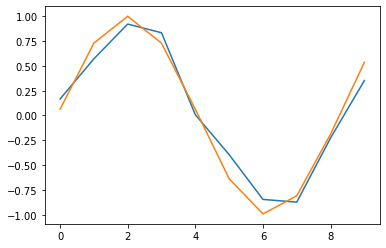

In [ ]:
# testing gru

for i in range(n_samples - batch_size):
  plt.figure()
  res = out_gru[i].detach().view(-1).numpy()
  tar = test_target_tensor[i].detach().view(-1).numpy()

  plt.plot(res)
  plt.plot(tar)

## **Βήμα 9 : Εισαγωγή Δεδομένων και Training-Testing-Validation split**


In [ ]:
import numpy as np
import librosa
from glob import glob
import os

from sklearn.preprocessing import StandardScaler

def fileReader(directory):
  # Parse relevant dataset info
  files = glob(os.path.join(directory, '*.wav'))
  #print(files)
  fnames = [f.split('/')[1].split('.')[0].split('_') for f in files]
  #print(fnames)
  ids = [f[2] for f in fnames]
  y = [int(f[0]) for f in fnames]
  speakers = [f[1] for f in fnames]
  _, Fs = librosa.core.load(files[0], sr=None)

  def read_wav(f):
      global Fs
      wav, fs = librosa.core.load(f, sr=None)
      return wav

  # Read all wavs
  wavs = [read_wav(f) for f in files]
  return wavs, Fs, ids, y, speakers

def datasetCreation(wavs, Fs, ids, y, speakers):
  # Extract MFCCs for all wavs
  window = 30 * Fs // 1000
  step = window // 2
  frames = [librosa.feature.mfcc(wav, Fs, n_fft=window, hop_length=window - step, n_mfcc=6).T for wav in wavs]
  # Print dataset info
  print('Total wavs: {}'.format(len(frames)))

  # Split to train-test
  X_train, y_train, spk_train = [], [], []
  X_test, y_test, spk_test = [], [], []
  test_indices = ['0', '1', '2', '3', '4']
  for idx, frame, label, spk in zip(ids, frames, y, speakers):
      if str(idx) in test_indices:
          X_test.append(frame)
          y_test.append(label)
          spk_test.append(spk)
      else:
          X_train.append(frame)
          y_train.append(label)
          spk_train.append(spk)

  print('Total Training vectors: {}'.format(len(X_train)))
  print('Total Testing vectors: {}'.format(len(X_test)))


  # Standardize data according to X_train (including validation set)
  scaler = StandardScaler()
  # scale train set
  scaler.fit(np.concatenate(X_train))
  for i in range(len(X_train)):
      X_train[i] = scaler.transform(X_train[i])

  # scale test set
  for i in range(len(X_test)):
      X_test[i] = scaler.transform(X_test[i])


  return X_train, X_test, y_train, y_test, spk_train, spk_test

In [ ]:
wavs, Fs, ids, y, speakers = fileReader("recordings")

In [ ]:
X_train, X_test, y_train, y_test, spk_train, spk_test = datasetCreation(wavs, Fs, ids, y, speakers)

Total wavs: 3000
Total Training vectors: 2700
Total Testing vectors: 300


In [ ]:
from sklearn.model_selection import train_test_split

#we use stratify so as to have balanced samples in every class
#we use the function train_test_split to split our training dataset in train and validation data
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, stratify=y_train)

In [ ]:
print(len(X_train))
print(len(X_test))
print(len(X_val))

2160
300
540


## **Βήμα 10 : Κατασκευή GMM-HMM**

In [ ]:
!pip install gensim==3.8.1 
!pip install matplotlib==3.1.0
!pip install nltk==3.4.4
!pip install numpy==1.16.4
!pip install pandas==0.24.2
!pip install pomegranate==0.12.0
!pip install scikit-image==0.15.0
!pip install scikit-learn==0.21.2
!pip install scipy==1.3.0
!pip install seaborn==0.9.0
!pip install torch==1.3.1
!pip install torchvision==0.4.2
!pip install tqdm==4.32.1

!pip install numba==0.48.0 --ignore-installed
!pip install librosa==0.7.1
!pip install joblib==0.17.0

In [ ]:
import numpy as np
from pomegranate import *


def train_hmm (X_data, max_iter, states= 3, mixtures = 5, gmm= True):
  #X = [] # data from a single digit (can be a numpy array)
  X = (np.vstack(X_data))
  #print(len(X))
  #n_states = 5 # the number of HMM states
  #n_mixtures = 5 # the number of Gaussians
  #gmm = True # whether to use GMM or plain Gaussian

  dists = [] # list of probability distributions for the HMM states
  for i in range(states):
      if gmm and mixtures>1:
          a = GeneralMixtureModel.from_samples(MultivariateGaussianDistribution, mixtures, np.float64(X))
      else:
          a = MultivariateGaussianDistribution.from_samples(np.float64(X))
      dists.append(a)

  #trans_mat = [] # your transition matrix
  trans_mat = np.zeros((states,states))
  for i in range(states):
   for j in range(states):
      if (i==j or j==i+1):
        trans_mat[i][j]=0.5 #we use uniform probability. every state can either transit to the right state or remain to the same state. 0.5 prob for every case 
  #the last state has not a right state
  trans_mat[states-1][states-1]=1

  starts = [] # your starting probability matrix
  #only the first state has probability = 1. the others are 0
  starts.append(1)
  for i in range(states-1):
    starts.append(0)
  starts = np.asarray(starts)
  ends = [] # your ending probability matrix
  #only the final state has end probability = 1. the others are 0
  for i in range(states-1):
    ends.append(0)
  ends.append(1)
  ends = np.asarray(ends)

  #data = [] # your data: must be a Python list that contains: 2D lists with the sequences (so its dimension would be num_sequences x seq_length x feature_dimension)
           # But be careful, it is not a numpy array, it is a Python list (so each sequence can have different length)

  data = X_data
  #print(data)

  # Define the GMM-HMM
  model = HiddenMarkovModel.from_matrix(trans_mat, dists, starts, ends, state_names=['s{}'.format(i) for i in range(states)])

# Fit the model
  model.fit(data, max_iterations = max_iter)

  return model 

# Predict a sequence
#sample = [] # a sample sequence
#logp, _ = model.viterbi(sample) # Run viterbi algorithm and return log-probability

In [ ]:
# we keep in a list the training data of every digit
digit_data = []

classes = set(y_train)
n_classes = len(classes)

for cl in range(n_classes):
  digit_data.append([])
  for i in range(len(X_train)):
    if (y_train[i]==cl):
      digit_data[cl].append(X_train[i])

# the list digit_data includes the samples we have for every single digit

## **Βήμα 11 : Εκπαίδευση ΗΜΜ**


In [ ]:
models = []

#we fit the 10 models and we save them in a list of models
#we will use the function "train_hmm" with max_iter = 5
#the default algorithm of fitting is Baum-Welch which is like EM. the algorithm ends when we reach to max_iter or we have convergence 

for i in range (n_classes):
  models.append(train_hmm(digit_data[i], 5))

## **Βήμα 12 : Validation - Testing**


In [ ]:
from sklearn.metrics import zero_one_loss

def evaluate_hmms (models, X, y):

  num_models = len(models)
  count_diff = np.zeros((len(models), len(models))) #it is for saving the sum of results
  y_pred = []
  for i in range(len(X)):
    probabilities = []
    for mod in range(num_models):
      logp, _ = models[mod].viterbi(X[i])
      probabilities.append(logp)
    y_pred.append(np.argmax(probabilities))
    count_diff[y[i], y_pred[i]] += 1 #we increase the counter in the model of the true digit in the place of the predicted digit

  return count_diff, 1-zero_one_loss(y, y_pred)

In [ ]:
count_diff, accuracy = evaluate_hmms(models, X_val, y_val)
print(count_diff, "\n", accuracy)

[[54.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0. 54.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0. 53.  0.  0.  0.  1.  0.  0.  0.]
 [ 0.  0.  1. 52.  0.  0.  0.  0.  1.  0.]
 [ 0.  1.  0.  0. 53.  0.  0.  0.  0.  0.]
 [ 0.  1.  0.  0.  0. 53.  0.  0.  0.  0.]
 [ 0.  0.  0.  3.  0.  0. 49.  0.  2.  0.]
 [ 0.  1.  0.  1.  0.  0.  0. 52.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1.  0. 53.  0.]
 [ 0.  1.  0.  0.  0.  0.  0.  0.  0. 53.]] 
 0.9740740740740741


In [ ]:
best_score = 0

#we find the best parameters by evaluating every possible model

for states in range(1,5):
  for gaussians in range(1,6):
      for max_iter in [5, 11, 15]:
        models = []
        for i in range (n_classes):
          models.append(train_hmm(digit_data[i], max_iter, states, gaussians))
        _, acc = evaluate_hmms(models, X_val, y_val)
        if (acc>best_score):
          best_state = states
          best_mixture = gaussians
          best_iter = max_iter
          best_score = acc

print("the best parameters are : ")
print("states = ", best_state)
print("mixtures = ", best_mixture)
print("max iterations = ", best_iter)
print("accuracy = ", best_score)

UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


UFuncTypeError: ignored

Exception ignored in: 'pomegranate.hmm.HiddenMarkovModel._from_summaries'
Traceback (most recent call last):
  File "pomegranate/bayes.pyx", line 808, in pomegranate.bayes.BayesModel.from_summaries
  File "pomegranate/distributions/MultivariateGaussianDistribution.pyx", line 272, in pomegranate.distributions.MultivariateGaussianDistribution.MultivariateGaussianDistribution.from_summaries
numpy.core._exceptions.UFuncTypeError: Cannot cast ufunc 'subtract' output from dtype('complex128') to dtype('float64') with casting rule 'same_kind'


the best parameters are : 
states =  4
mixtures =  4
max iterations =  15
accuracy =  0.9796296296296296


In [ ]:
# evaluating our models on our test set
# using the best training parameters from the evaluation process

best_state = 4
best_mixture = 4
best_iter = 15

models = []
for i in range (n_classes):
  models.append(train_hmm(digit_data[i], best_iter, best_state, best_mixture))
evaluate_hmms(models, X_test, y_test)

(array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  1.,  0.,  0., 29.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  2.,  0.,  0., 25.,  2.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0.,  1.,  0., 28.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.]]),
 0.9733333333333334)

## **Βήμα 13 : Confusion Matrices**

In [ ]:
# evaluating on our validation set
models = []
for i in range (n_classes):
  models.append(train_hmm(digit_data[i], best_iter, best_state, best_mixture))
confusion_matrix_val, acc_val = evaluate_hmms(models, X_val, y_val)

# evaluating on our test set
models = []
for i in range (n_classes):
  models.append(train_hmm(digit_data[i], best_iter, best_state, best_mixture))
confusion_matrix_test, acc_test = evaluate_hmms(models, X_test, y_test)

Accuracy on Validation Set: 0.9722222222222222
Accuracy on Testing Set: 0.9566666666666667


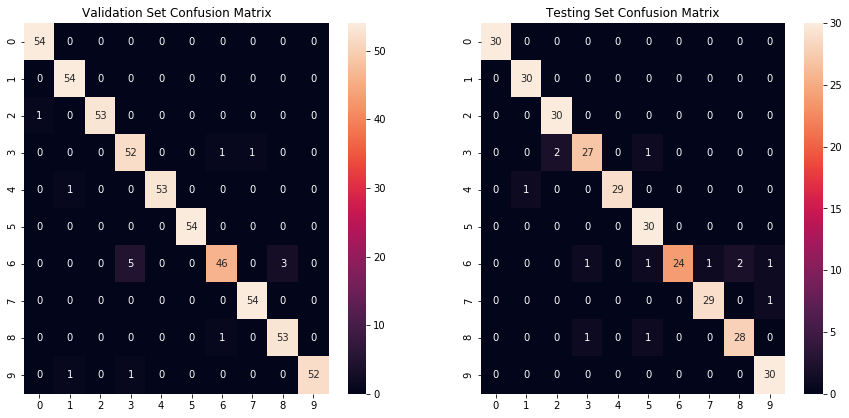

In [ ]:
import seaborn as sn
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15,15))

fig.add_subplot(2, 2, 1)
sn.heatmap(confusion_matrix_val, annot=True).set_title('Validation Set Confusion Matrix')

print("Accuracy on Validation Set: {}".format(acc_val))

fig.add_subplot(2, 2, 2)
sn.heatmap(confusion_matrix_test, annot=True).set_title('Testing Set Confusion Matrix')

print("Accuracy on Testing Set: {}".format(acc_test))

## **Βήμα 14 : LSTM**


In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn


class FrameLevelDataset(Dataset):
    def __init__(self, feats, labels):
        """
            feats: Python list of numpy arrays that contain the sequence features.
                   Each element of this list is a numpy array of shape seq_length x feature_dimension
            labels: Python list that contains the label for each sequence (each label must be an integer)
        """
        self.lengths =  []
        for i in range(len(feats)):
          self.lengths.append(len(feats[i]))

        self.feats = self.zero_pad_and_stack(feats)
        if isinstance(labels, (list, tuple)):
            self.labels = np.array(labels).astype('int64')

    def zero_pad_and_stack(self, x):
        """
            This function performs zero padding on a list of features and forms them into a numpy 3D array
            returns
                padded: a 3D numpy array of shape num_sequences x max_sequence_length x feature_dimension
        """
        padded = []
        # --------------- Insert your code here ---------------- #
        num_sequenses = len(x)
        feature_dimension = len(x[0][0])
        max_sequence_length = len(x[0])
        for i in range(len(x)):
          if max_sequence_length < len(x[i]):
            max_sequence_length = len(x[i])

        for i_seq in range(len(x)):
          padded_seq = np.zeros((max_sequence_length, feature_dimension))
          for i_feat in range(max_sequence_length):
            if i_feat < len(x[i_seq]):
              padded_seq[i_feat] = x[i_seq][i_feat]
            else:
              padded_seq[i_feat] = np.zeros(feature_dimension)
          padded.append(padded_seq)

        return np.array(padded)

    def __getitem__(self, item):
        return self.feats[item], self.labels[item], self.lengths[item]

    def __len__(self):
        return len(self.feats)


class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers = 1, bidirectional=False, dropout_probability=0):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout_probability = dropout_probability
        self.rnn_size = rnn_size
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.rnn_size, num_layers=self.num_layers,
                            batch_first=True, dropout=self.dropout_probability, bidirectional=self.bidirectional)
        self.linear = nn.Linear(self.feature_size, self.output_dim)


    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index
            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network

        batch_size = len(x)
        seq_len = len(x[0])

        # initialize the hidden state of lstm
        num_of_directions = 1
        if self.bidirectional == True:
          num_of_directions = 2
        hidden = torch.randn(self.num_layers * num_of_directions, batch_size, self.rnn_size)
        cell_state = torch.randn(self.num_layers * num_of_directions, batch_size, self.rnn_size)
        #cell_state = init_cell_state(batch_size)

        # pass our data and state to lstm
        outputs, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))

        last_outputs = self.last_timestep(outputs, lengths, self.bidirectional)
        last_outputs = self.linear(last_outputs)
        return last_outputs


    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [ ]:
# example of FrameLevelDataset
data = [np.ones((3, 2)) , np.ones((2, 2)), np.ones((4, 2))]
data[0]
labels = [[1, 0, 0], [0, 1, 0], [0, 0, 1]] # using one hot label encoding

ds = FrameLevelDataset(data, labels)
ds.__getitem__(0)

(array([[1., 1.],
        [1., 1.],
        [1., 1.],
        [0., 0.]]), array([1, 0, 0]), 3)

In [ ]:
# prepare our dataSet
# Firstly we need to transform our ground truth labels into on hot label decoding

def label_to_one_hot(label, number_of_labels):
  code = []
  for i in range(number_of_labels):
    if i == label:
      code.append(1)
    else:
      code.append(0)
  return code

def one_hot_to_label(one_hot_label):
  for i in range(len(one_hot_label)):
    if one_hot_label[i] == 1:
      return i
  return -1

number_of_labels = len(set(y_train)) # == 10 (different digits)
y_train_one_hot = [label_to_one_hot(label, number_of_labels) for label in y_train]

# Secondly we pass our Dataset into our FrameLevelDataset for padding and better management
ds = FrameLevelDataset(X_train, y_train_one_hot)

In [ ]:
# next we define our lstm's parameters
feat_0, label_0, length_0 = ds.__getitem__(0)
# every input's dimensions
padded_seq_len, input_dim = feat_0.shape
# so we need an rnn padded_seq_len long
rnn_size = padded_seq_len
# get every labels' dimensions
(output_dim,) = label_0.shape
# we define how many layers we want
num_layers = 1
# we define the size of the batches
batch_size = 32

In [ ]:
import torch
from torch import nn as nn
from torch import optim
import joblib

def train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers, epochs, dropout_probability=0, regularization =0, bidirectional = False, validation = False, early_stopping=False, checkpoints=False, shuffle=True):

  # we create our length and target tensors
  # our target will be a 2d tensor of dimensions n_samples x output_dim
  target_tensor = torch.zeros(batch_size, output_dim)
  # and we need the real lengths of our vectors in a Nx1 tensor
  lengths = torch.zeros(batch_size, 1, dtype=torch.int64)

  if (validation==True):
    # prepare our validation tensors
    n_categories = 10
    y_val_one_hot = [label_to_one_hot(label, n_categories) for label in y_val]
    ds = FrameLevelDataset(X_val, y_val_one_hot)
    feat_0, label_0, length_0 = ds.__getitem__(0)
    # every input's dimensions
    padded_seq_len, input_dim = feat_0.shape
    n_val_samples = ds.__len__()
    # our input will be a 3d tensor of dimensions n_val_samples x padded_seq_len x input_dim
    input_val_tensor = torch.zeros(n_val_samples, padded_seq_len, input_dim)
    # our target will be a 2d tensor of dimensions n_val_samples x output_dim
    target_val_tensor = torch.zeros(n_val_samples, output_dim)
    # we need the real lengths of our vectors in a Nx1 tensor
    val_lengths = torch.zeros(n_val_samples, 1, dtype=torch.int64)
    for i in range(n_val_samples):
      feat, label, length = ds.__getitem__(i)
      input_val_tensor[i] = torch.from_numpy(feat)
      target_val_tensor[i] = torch.from_numpy(label)
      val_lengths[i][0] = length

  model = BasicLSTM(input_dim=input_dim, rnn_size=rnn_size, output_dim=output_dim,
                  num_layers=num_layers, bidirectional=bidirectional, dropout_probability = dropout_probability) 
  

  loss_function = nn.MSELoss()
  # define an optimizer with L2 regularization
  optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=regularization) # tried 1, 0.1, 0.01

  ind = np.arange(len(X_train))

  for epoch in range(epochs):
    if (shuffle == True):
      np.random.shuffle(ind)
      X_train = [X_train[i] for i in ind]
      y_train = [y_train[i] for i in ind]
    train_loss = 0
    if (validation==True) : 
      val_loss = 0
    for batch in range(len(X_train)//batch_size):
      # we split our dataset into batches
      X_batch = X_train[batch*batch_size:batch*batch_size+batch_size][:][:]
      y_batch = y_train[batch*batch_size:batch*batch_size+batch_size][:][:]
      y_batch_one_hot = [label_to_one_hot(label, number_of_labels) for label in y_batch]
      # we pad
      ds = FrameLevelDataset(X_batch , y_batch_one_hot)
      feat_0, _, _ = ds.__getitem__(0)
      padded_seq_len, input_dim = feat_0.shape
      # our input will be a 3d tensor of dimensions n_samples x padded_seq_len x input_dim
      input_tensor = torch.zeros(batch_size, padded_seq_len, input_dim)
      for i in range(len(X_batch)):
        feat, label, length = ds.__getitem__(i)
        input_tensor[i] = torch.from_numpy(feat)
        lengths[i][0] = length
        target_tensor[i] = torch.from_numpy(np.array(y_batch_one_hot[i]))
    
      # and train
      optimizer.zero_grad()
      out = model(input_tensor, lengths)
      loss = loss_function(out, target_tensor)
      loss.backward()
      optimizer.step()
      train_loss = train_loss + loss.item()
    print("epoch : ", epoch, ",training loss = ", train_loss/(len(X_train)//batch_size))

    if (validation==True):
      # see our model's performance on validation set for each epoch
      out_val = model(input_val_tensor, val_lengths)
      loss_val = loss_function(out_val, target_val_tensor)
      val_loss = val_loss + loss_val.item()
      _, accuracy = eval_lstm(model, X_val, y_val)
      print("Accuracy in validation set = ", accuracy*100,"%")
      print("epoch : ", epoch, ",validation loss = ", val_loss/(len(X_val)//batch_size))
    
    # early stopping implementation
    if (early_stopping==True):
      # setting some parameters
      if epoch == 0:
        last_models = []
        last_accuracies = []
        patience = 4 # we'll wait for patience number of epochs
        tolerance = 0.01 # our tolerance of the accuracy on the evaluation set (1%)
      # get the current accuracy
      _, accuracy = eval_lstm(model, X_val, y_val)
      if (len(last_models) >= patience):
        # compare this accuracy with every last accuracy
        worst_acc = min(last_accuracies)
        # if it violates our tolerance we stop the training and return the best model
        if (worst_acc > accuracy + tolerance):
          best = np.argmax(np.asarray(last_accuracies))
          print("----------------------------------------------------------------")
          print("Early stopping. Returning model of epoch {} with accuracy {} on evaluation test".format(epoch - patience + best, last_accuracies[best]))
          return last_models[best]
        # dequeue
        last_models.pop(0)
        last_accuracies.pop(0)
      # enqueue
      last_models.append(model)
      last_accuracies.append(accuracy)

    # checkpoint implementation
    if (checkpoints == True):
      if epoch == 0:
        check_models = []
        check_accuracies = []
        check_points_frequency = 5 # We save the best model (out of the last 5) every 5 epochs
      _, accuracy = eval_lstm(model, X_val, y_val)
      check_models.append(model)
      check_accuracies.append(accuracy)
      if (len(check_models) >= check_points_frequency):
        best = np.argmax(np.asarray(check_accuracies))
        print("================== Saved checkpoint ==================")
        joblib.dump(check_models[best], "model_checkpoint_{}.pkl".format(epoch)) 
        check_models = []
        check_accuracies = []


  return model


In [ ]:
from sklearn.metrics import zero_one_loss

# we implement a function for evaluating our lstm model

def eval_lstm(model, X, y):
  # create input tensors
  n_categories = len(set(y))
  y_one_hot = [label_to_one_hot(label, n_categories) for label in y]
  ds = FrameLevelDataset(X, y_one_hot)
  feat_0, label_0, length_0 = ds.__getitem__(0)
  # every input's dimensions
  padded_seq_len, input_dim = feat_0.shape
  n_samples = ds.__len__()
  # our input will be a 3d tensor of dimensions n_samples x padded_seq_len x input_dim
  input_tensor = torch.zeros(n_samples, padded_seq_len, input_dim)
  # we need the real lengths of our vectors in a Nx1 tensor
  lengths = torch.zeros(n_samples, 1, dtype=torch.int64)
  for i in range(n_samples):
    feat, label, length = ds.__getitem__(i)
    input_tensor[i] = torch.from_numpy(feat)
    lengths[i][0] = length

  # give our test set to our model
  out = model(input_tensor, lengths)
  y_pred = []
  for i in range(len(out)):
    probabilities = out[i].detach().view(-1).numpy()
    #print(probabilities)
    y_pred.append(np.argmax(probabilities))
  
  #print("predictions = ", y_pred)
  #print("true values = ", y)
  count_diff = np.zeros((n_categories, n_categories)) #it is for saving the sum of results
  for i in range(len(X)):
    count_diff[y[i], y_pred[i]] += 1 #we increase the counter in the model of the true digit in the place of the predicted digit

  return count_diff, 1-zero_one_loss(y, y_pred)

In [ ]:
#only training loss 
simply_trained_model = train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers, epochs=30, dropout_probability=0, regularization = 0, bidirectional = False, validation = False)

epoch :  0 ,training loss =  0.07282869300957936
epoch :  1 ,training loss =  0.04685428933198772
epoch :  2 ,training loss =  0.02985253490841211
epoch :  3 ,training loss =  0.020128031289065953
epoch :  4 ,training loss =  0.014045595281771314
epoch :  5 ,training loss =  0.008610769623278905
epoch :  6 ,training loss =  0.00829797729835915
epoch :  7 ,training loss =  0.008380273169379181
epoch :  8 ,training loss =  0.006915336547753037
epoch :  9 ,training loss =  0.004448093077751683
epoch :  10 ,training loss =  0.004841557688274379
epoch :  11 ,training loss =  0.003804843353260475
epoch :  12 ,training loss =  0.003776886615095966
epoch :  13 ,training loss =  0.005043905061572346
epoch :  14 ,training loss =  0.004571452052262959
epoch :  15 ,training loss =  0.006729431349589531
epoch :  16 ,training loss =  0.0049536992055572455
epoch :  17 ,training loss =  0.008452610140527362
epoch :  18 ,training loss =  0.003934274426723983
epoch :  19 ,training loss =  0.004342158912

In [ ]:
#with validation loss and accuracy
simply_trained_model =  train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers, epochs=30, dropout_probability=0, regularization = 0, bidirectional = False, validation = True)

epoch :  0 ,training loss =  0.06893675357325753
Accuracy in validation set =  67.96296296296296 %
epoch :  0 ,validation loss =  0.003466065274551511
epoch :  1 ,training loss =  0.0432912453508644
Accuracy in validation set =  79.44444444444444 %
epoch :  1 ,validation loss =  0.0020510072354227304
epoch :  2 ,training loss =  0.027206948054815407
Accuracy in validation set =  89.25925925925927 %
epoch :  2 ,validation loss =  0.0012718779034912586
epoch :  3 ,training loss =  0.016757222239984507
Accuracy in validation set =  92.77777777777779 %
epoch :  3 ,validation loss =  0.0008859737426973879
epoch :  4 ,training loss =  0.011648230730736656
Accuracy in validation set =  93.7037037037037 %
epoch :  4 ,validation loss =  0.0008372677839361131
epoch :  5 ,training loss =  0.01001917618785554
Accuracy in validation set =  95.0 %
epoch :  5 ,validation loss =  0.0007893528090789914
epoch :  6 ,training loss =  0.009121269164884935
Accuracy in validation set =  91.2962962962963 %
ep

In [ ]:
# and we test our model
eval_lstm(simply_trained_model, X_test, y_test)

(array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 29.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0., 29.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 29.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., 28.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.,  0., 29.]]), 0.98)

In [ ]:
#with dropout 0.5
model = train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers=2, epochs=30, dropout_probability=0.5, regularization = 0, bidirectional = False, validation = False)
eval_lstm(model, X_test, y_test)

epoch :  0 ,training loss =  0.07558280107245516
epoch :  1 ,training loss =  0.04672704192239847
epoch :  2 ,training loss =  0.030517739507911812
epoch :  3 ,training loss =  0.019022390698152248
epoch :  4 ,training loss =  0.016401409692784297
epoch :  5 ,training loss =  0.012217462716151529
epoch :  6 ,training loss =  0.008538216057080609
epoch :  7 ,training loss =  0.012131272905520093
epoch :  8 ,training loss =  0.013495057131469583
epoch :  9 ,training loss =  0.007430236737952748
epoch :  10 ,training loss =  0.005800813144601103
epoch :  11 ,training loss =  0.004520993857859953
epoch :  12 ,training loss =  0.0068878507347596785
epoch :  13 ,training loss =  0.0063960641255921945
epoch :  14 ,training loss =  0.006451710173338929
epoch :  15 ,training loss =  0.003968184859033173
epoch :  16 ,training loss =  0.0032828719574096265
epoch :  17 ,training loss =  0.003659165500830025
epoch :  18 ,training loss =  0.010452901552702343
epoch :  19 ,training loss =  0.00473992

(array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 26.,  0.,  0.,  0.,  3.,  0.,  1.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 29.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 29.,  0.],
        [ 1.,  0.,  0.,  0.,  0.,  2.,  0.,  0.,  0., 27.]]), 0.97)

In [ ]:
#with regularization
model = train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers=1, epochs=30, dropout_probability=0, regularization = 1e-5, bidirectional = False, validation = False)
eval_lstm(model, X_test, y_test)

epoch :  0 ,training loss =  0.07166489208144929
epoch :  1 ,training loss =  0.047507672223137384
epoch :  2 ,training loss =  0.02738884990729058
epoch :  3 ,training loss =  0.01935172300618976
epoch :  4 ,training loss =  0.015756539889235994
epoch :  5 ,training loss =  0.010649681278963142
epoch :  6 ,training loss =  0.010476237190748328
epoch :  7 ,training loss =  0.008233936510479717
epoch :  8 ,training loss =  0.0067843517093960914
epoch :  9 ,training loss =  0.008874986372860287
epoch :  10 ,training loss =  0.007147108727662977
epoch :  11 ,training loss =  0.010854279438256105
epoch :  12 ,training loss =  0.008370913394879716
epoch :  13 ,training loss =  0.005258531287076202
epoch :  14 ,training loss =  0.004716445045517896
epoch :  15 ,training loss =  0.0038595217386079923
epoch :  16 ,training loss =  0.007580380252590264
epoch :  17 ,training loss =  0.006800454408764395
epoch :  18 ,training loss =  0.006804283970702828
epoch :  19 ,training loss =  0.0064514658

(array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 29.,  0.,  0.,  1.,  0.,  0.,  0.,  0.,  0.],
        [ 2.,  0., 28.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 29.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  1.,  0.,  0., 28.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  4.,  0., 26.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.]]),
 0.9666666666666667)

In [ ]:
#with both dropout and regularization
model = train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers=2, epochs=30, dropout_probability=0.5, regularization = 1e-5, bidirectional = False, validation = False)
eval_lstm(model, X_test, y_test)

epoch :  0 ,training loss =  0.07231448451752093
epoch :  1 ,training loss =  0.046172591315498994
epoch :  2 ,training loss =  0.03573450351606554
epoch :  3 ,training loss =  0.02278113381158727
epoch :  4 ,training loss =  0.017011214277025923
epoch :  5 ,training loss =  0.014367496372381253
epoch :  6 ,training loss =  0.00986272328074521
epoch :  7 ,training loss =  0.009498418399146688
epoch :  8 ,training loss =  0.008033460716772547
epoch :  9 ,training loss =  0.005603826585670572
epoch :  10 ,training loss =  0.006567187442221859
epoch :  11 ,training loss =  0.00871102561923995
epoch :  12 ,training loss =  0.0064632880185216445
epoch :  13 ,training loss =  0.005943080579771646
epoch :  14 ,training loss =  0.0046885419956672544
epoch :  15 ,training loss =  0.0055414537426584694
epoch :  16 ,training loss =  0.0068391210802677856
epoch :  17 ,training loss =  0.006869936916184848
epoch :  18 ,training loss =  0.006485547587178203
epoch :  19 ,training loss =  0.0036745885

(array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 29.,  0.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 25.,  0.,  5.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  0.,  0.,  0., 29.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.]]),
 0.9766666666666667)

In [ ]:
# training using early stopping and checkpoints
model = train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers=1, epochs=50, validation = True, early_stopping=True, checkpoints=True)
eval_lstm(model, X_test, y_test)

epoch :  0 ,training loss =  0.07339015397340504
Accuracy in validation set =  47.40740740740741 %
epoch :  0 ,validation loss =  0.004078303463757038
epoch :  1 ,training loss =  0.04732665906090345
Accuracy in validation set =  74.25925925925925 %
epoch :  1 ,validation loss =  0.0024026886094361544
epoch :  2 ,training loss =  0.03187277276458135
Accuracy in validation set =  81.11111111111111 %
epoch :  2 ,validation loss =  0.001970782410353422
epoch :  3 ,training loss =  0.02187808783752705
Accuracy in validation set =  86.66666666666667 %
epoch :  3 ,validation loss =  0.0016082522924989462
epoch :  4 ,training loss =  0.014617836672757099
Accuracy in validation set =  91.66666666666666 %
epoch :  4 ,validation loss =  0.0008639317820779979
================== Saved checkpoint ==================
epoch :  5 ,training loss =  0.010372624312068767
Accuracy in validation set =  94.44444444444444 %
epoch :  5 ,validation loss =  0.0007010519620962441
epoch :  6 ,training loss =  0.00

(array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 28.,  0.,  0.,  0.,  2.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 5.,  0., 15.,  0., 10.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 28.,  1.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  1.,  0.,  0., 29.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 29.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  3.,  0., 26.]]), 0.9)

In [ ]:
#bidirectional
model = train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers=1, epochs=30, dropout_probability=0, regularization = 0, bidirectional = True, validation = False)
eval_lstm(model, X_test, y_test)

epoch :  0 ,training loss =  0.047536926955651884
epoch :  1 ,training loss =  0.026092396826664015
epoch :  2 ,training loss =  0.015064025353362312
epoch :  3 ,training loss =  0.012328997462876697
epoch :  4 ,training loss =  0.009617073996576355
epoch :  5 ,training loss =  0.006118966589695705
epoch :  6 ,training loss =  0.005800955643905188
epoch :  7 ,training loss =  0.0050716829597393966
epoch :  8 ,training loss =  0.005796455701729699
epoch :  9 ,training loss =  0.004534276065055225
epoch :  10 ,training loss =  0.0032915679856078393
epoch :  11 ,training loss =  0.004855575689823547
epoch :  12 ,training loss =  0.006003348792750222
epoch :  13 ,training loss =  0.004597751799025642
epoch :  14 ,training loss =  0.0030949861749506266
epoch :  15 ,training loss =  0.0029630874684984003
epoch :  16 ,training loss =  0.0030308284565681285
epoch :  17 ,training loss =  0.0018712875881552028
epoch :  18 ,training loss =  0.0013310264721304288
epoch :  19 ,training loss =  0.00

(array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 29.,  1.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 29.,  0.,  0.,  1.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 29.,  1.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.],
        [ 0.,  0.,  1.,  0.,  0.,  1.,  2., 26.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  2.,  0., 28.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 30.]]), 0.97)

## Bonus

In [ ]:
import os
import numpy as np
import torch
from torch.utils.data import Dataset
import torch.nn as nn

class BasicLSTM(nn.Module):
    def __init__(self, input_dim, rnn_size, output_dim, num_layers = 1, bidirectional=False, dropout_probability=0):
        super(BasicLSTM, self).__init__()
        self.bidirectional = bidirectional
        self.feature_size = rnn_size * 2 if self.bidirectional else rnn_size

        # --------------- Insert your code here ---------------- #
        # Initialize the LSTM, Dropout, Output layers
        self.input_dim = input_dim
        self.output_dim = output_dim
        self.num_layers = num_layers
        self.dropout_probability = dropout_probability
        self.rnn_size = rnn_size
        self.lstm = nn.LSTM(input_size=self.input_dim, hidden_size=self.rnn_size, num_layers=self.num_layers,
                            batch_first=True, dropout=self.dropout_probability, bidirectional=self.bidirectional)
        self.linear = nn.Linear(self.feature_size, self.output_dim)


    def forward(self, x, lengths):
        """ 
            x : 3D numpy array of dimension N x L x D
                N: batch index
                L: sequence index
                D: feature index
            lengths: N x 1
         """
        
        # --------------- Insert your code here ---------------- #
        
        # You must have all of the outputs of the LSTM, but you need only the last one (that does not exceed the sequence length)
        # To get it use the last_timestep method
        # Then pass it through the remaining network

        batch_size = len(x)
        seq_len = len(x[0])

        # initialize the hidden state of lstm
        num_of_directions = 1
        if self.bidirectional == True:
          num_of_directions = 2
        hidden = torch.randn(self.num_layers * num_of_directions, batch_size, self.rnn_size)
        cell_state = torch.randn(self.num_layers * num_of_directions, batch_size, self.rnn_size)

        # use pack_padded_sequence so that padded items won't be shown to the lstm
        x = nn.utils.rnn.pack_padded_sequence(x, lengths.view(-1), batch_first=True)

        # pass our data and state to lstm
        outputs, (hidden, cell_state) = self.lstm(x, (hidden, cell_state))

        # undo the packing
        outputs, _ = nn.utils.rnn.pad_packed_sequence(outputs, batch_first=True)
        
        last_outputs = self.last_timestep(outputs, lengths, self.bidirectional)
        last_outputs = self.linear(last_outputs)
        return last_outputs


    def last_timestep(self, outputs, lengths, bidirectional=False):
        """
            Returns the last output of the LSTM taking into account the zero padding
        """
        if bidirectional:
            forward, backward = self.split_directions(outputs)
            last_forward = self.last_by_index(forward, lengths)
            last_backward = backward[:, 0, :]
            # Concatenate and return - maybe add more functionalities like average
            return torch.cat((last_forward, last_backward), dim=-1)

        else:
            return self.last_by_index(outputs, lengths)

    @staticmethod
    def split_directions(outputs):
        direction_size = int(outputs.size(-1) / 2)
        forward = outputs[:, :, :direction_size]
        backward = outputs[:, :, direction_size:]
        return forward, backward

    @staticmethod
    def last_by_index(outputs, lengths):
        # Index of the last output for each sequence.
        idx = (lengths - 1).view(-1, 1).expand(outputs.size(0),
                                               outputs.size(2)).unsqueeze(1)
        return outputs.gather(1, idx).squeeze()

In [ ]:
# sort set by vectors' lengths
def sort_key(tuple):
  len, _, _ = tuple
  return len

def sort_by_length(X, y):
  lengths = [len(vector) for vector in X]
  zippedList = list(zip(lengths, X, y))
  zippedList.sort(key=sort_key, reverse=True)
  X_sorted = [vector for (_, vector, _) in zippedList]
  y_sorted = [label for (_, _, label) in zippedList]
  return X_sorted, y_sorted

X_train, y_train = sort_by_length(X_train, y_train)
X_val, y_val = sort_by_length(X_val, y_val)
X_test, y_test = sort_by_length(X_test, y_test)

In [ ]:
# using the bonus implementation
model = train_lstm (X_train, y_train, batch_size, input_dim, rnn_size, output_dim, num_layers=1, epochs=30, shuffle=False)
eval_lstm(model, X_test, y_test)

epoch :  0 ,training loss =  0.06970760860105059
epoch :  1 ,training loss =  0.06335207708735964
epoch :  2 ,training loss =  0.05374296070702041
epoch :  3 ,training loss =  0.03714255410343854
epoch :  4 ,training loss =  0.030817514897060038
epoch :  5 ,training loss =  0.026978222535116905
epoch :  6 ,training loss =  0.01791516217444815
epoch :  7 ,training loss =  0.01329494987044539
epoch :  8 ,training loss =  0.012347852369881611
epoch :  9 ,training loss =  0.007923218647518488
epoch :  10 ,training loss =  0.009121411446996255
epoch :  11 ,training loss =  0.009615363016265876
epoch :  12 ,training loss =  0.006288898762996628
epoch :  13 ,training loss =  0.007595129139068078
epoch :  14 ,training loss =  0.007878604855861015
epoch :  15 ,training loss =  0.007059202001277191
epoch :  16 ,training loss =  0.00480435990360079
epoch :  17 ,training loss =  0.0053950995050454096
epoch :  18 ,training loss =  0.004493725088202575
epoch :  19 ,training loss =  0.003755073202947

(array([[30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0., 30.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0., 29.,  0.,  0.,  0.,  1.,  0.,  0.],
        [ 0.,  0.,  0.,  0., 29.,  0.,  0.,  0.,  1.,  0.],
        [ 0.,  0.,  0.,  0.,  0., 30.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0., 29.,  0.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0., 30.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  1.,  0., 29.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  1.,  0.,  0.,  0., 29.]]),
 0.9833333333333333)